<a href="https://colab.research.google.com/github/abxda/COLMEX-ML/blob/main/Semana_09_CENSO_DENUE_COLMEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://drive.google.com/file/d/1LVPNaUxto31HE-UQIO1-4l6XPER9Ry5l/view?usp=sharing
#https://drive.google.com/file/d/1O_GKDVQSoBAEuHjCMHMkknDxSuZd3i_A/view?usp=sharing
# Instalar gdown si no está disponible
#!pip install gdown

In [25]:
pip install pyarrow geopandas

In [23]:

import duckdb
import pandas as pd
import geopandas as gpd
from shapely import wkb

In [ ]:
# Descargar el archivo usando el ID de Google Drive
!gdown --id 1LVPNaUxto31HE-UQIO1-4l6XPER9Ry5l

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1LVPNaUxto31HE-UQIO1-4l6XPER9Ry5l
From (redirected): https://drive.google.com/uc?id=1LVPNaUxto31HE-UQIO1-4l6XPER9Ry5l&confirm=t&uuid=2df952f3-c315-4fa7-930a-0f113082ae89
To: /content/datos_censo_nacional_s9.duckdb
100% 1.03G/1.03G [00:17<00:00, 57.9MB/s]


In [ ]:
!gdown --id 1O_GKDVQSoBAEuHjCMHMkknDxSuZd3i_A

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1O_GKDVQSoBAEuHjCMHMkknDxSuZd3i_A
From (redirected): https://drive.google.com/uc?id=1O_GKDVQSoBAEuHjCMHMkknDxSuZd3i_A&confirm=t&uuid=709ef796-2447-48f7-81f3-864d32cfae84
To: /content/denue_total_4.duckdb
100% 1.04G/1.04G [00:11<00:00, 88.1MB/s]


In [7]:
!ls -lh

total 2.0G
-rw-r--r-- 1 root root 980M Mar 18 19:17 datos_censo_nacional_s9.duckdb
-rw-r--r-- 1 root root 993M Mar  6 19:52 denue_total_4.duckdb
drwxr-xr-x 1 root root 4.0K Mar 19 13:34 sample_data


In [9]:
# Conectar a la base de datos
db_path = "/content/datos_censo_nacional_s9.duckdb"
conn = duckdb.connect(db_path)

# Obtener listado de tablas
tables = conn.execute("SHOW TABLES").fetchall()

# Generar reporte
reporte = {}
for table in tables:
    table_name = table[0]
    # Obtener metadatos de columnas
    columns = conn.execute(f"PRAGMA table_info({table_name})").fetchall()
    # Almacenar nombre y tipo de cada columna
    reporte[table_name] = [(col[1], col[2]) for col in columns]

# Mostrar resultados en formato legible
for tabla, columnas in reporte.items():
    print(f"\n[ Tabla: {tabla} ]")
    print("--------------------")
    for columna in columnas:
        print(f"- {columna[0]} ({columna[1]})")
    print("--------------------")

conn.close()


[ Tabla: censo_geo_int ]
--------------------
- CVEGEO (VARCHAR)
- NOM_ENT (VARCHAR)
- NOM_MUN (VARCHAR)
- NOM_LOC (VARCHAR)
- POBTOT (BIGINT)
- POBFEM (INTEGER)
- POBMAS (INTEGER)
- P_0A2 (INTEGER)
- P_0A2_F (INTEGER)
- P_0A2_M (INTEGER)
- P_3YMAS (INTEGER)
- P_3YMAS_F (INTEGER)
- P_3YMAS_M (INTEGER)
- P_5YMAS (INTEGER)
- P_5YMAS_F (INTEGER)
- P_5YMAS_M (INTEGER)
- P_12YMAS (INTEGER)
- P_12YMAS_F (INTEGER)
- P_12YMAS_M (INTEGER)
- P_15YMAS (INTEGER)
- P_15YMAS_F (INTEGER)
- P_15YMAS_M (INTEGER)
- P_18YMAS (INTEGER)
- P_18YMAS_F (INTEGER)
- P_18YMAS_M (INTEGER)
- P_3A5 (INTEGER)
- P_3A5_F (INTEGER)
- P_3A5_M (INTEGER)
- P_6A11 (INTEGER)
- P_6A11_F (INTEGER)
- P_6A11_M (INTEGER)
- P_8A14 (INTEGER)
- P_8A14_F (INTEGER)
- P_8A14_M (INTEGER)
- P_12A14 (INTEGER)
- P_12A14_F (INTEGER)
- P_12A14_M (INTEGER)
- P_15A17 (INTEGER)
- P_15A17_F (INTEGER)
- P_15A17_M (INTEGER)
- P_18A24 (INTEGER)
- P_18A24_F (INTEGER)
- P_18A24_M (INTEGER)
- P_15A49_F (INTEGER)
- P_60YMAS (INTEGER)
- P_60YMAS_F (IN

In [10]:
# Conectar a la base de datos
db_path = "/content/denue_total_4.duckdb"
conn = duckdb.connect(db_path)

# Obtener listado de tablas
tables = conn.execute("SHOW TABLES").fetchall()

# Generar reporte
reporte = {}
for table in tables:
    table_name = table[0]
    # Obtener metadatos de columnas
    columns = conn.execute(f"PRAGMA table_info({table_name})").fetchall()
    # Almacenar nombre y tipo de cada columna
    reporte[table_name] = [(col[1], col[2]) for col in columns]

# Mostrar resultados en formato legible
for tabla, columnas in reporte.items():
    print(f"\n[ Tabla: {tabla} ]")
    print("--------------------")
    for columna in columnas:
        print(f"- {columna[0]} ({columna[1]})")
    print("--------------------")


# Verificar creación del nuevo archivo
print("\nBase de datos creada:")
!ls -lh {db_path}

conn.close()


[ Tabla: denue ]
--------------------
- id (INTEGER)
- clee (VARCHAR)
- nom_estab (VARCHAR)
- raz_social (VARCHAR)
- codigo_act (VARCHAR)
- nombre_act (VARCHAR)
- per_ocu (VARCHAR)
- tipo_vial (VARCHAR)
- nom_vial (VARCHAR)
- tipo_v_e_1 (VARCHAR)
- nom_v_e_1 (VARCHAR)
- tipo_v_e_2 (VARCHAR)
- nom_v_e_2 (VARCHAR)
- tipo_v_e_3 (VARCHAR)
- nom_v_e_3 (VARCHAR)
- numero_ext (VARCHAR)
- letra_ext (VARCHAR)
- edificio (VARCHAR)
- edificio_e (VARCHAR)
- numero_int (VARCHAR)
- letra_int (VARCHAR)
- tipo_asent (VARCHAR)
- nomb_asent (VARCHAR)
- tipoCenCom (VARCHAR)
- nom_CenCom (VARCHAR)
- num_local (VARCHAR)
- cod_postal (VARCHAR)
- cve_ent (VARCHAR)
- entidad (VARCHAR)
- cve_mun (VARCHAR)
- municipio (VARCHAR)
- cve_loc (VARCHAR)
- localidad (VARCHAR)
- ageb (VARCHAR)
- manzana (VARCHAR)
- telefono (VARCHAR)
- correoelec (VARCHAR)
- www (VARCHAR)
- tipoUniEco (VARCHAR)
- latitud (DOUBLE)
- longitud (DOUBLE)
- fecha_alta (VARCHAR)
- geometry (GEOMETRY)
--------------------

Base de datos cread

In [11]:
# Crear nueva base de datos
new_db_path = "/content/denue_total_est_per_ocu_final_5.duckdb"
conn = duckdb.connect(new_db_path)

# Cargar extensión espacial
conn.install_extension("spatial")
conn.load_extension("spatial")

# Crear tabla compatible
conn.execute(f"""
ATTACH DATABASE '/content/denue_total_4.duckdb' AS source_db;

CREATE TABLE denue_est_per_ocu AS
SELECT
    id,
    clee,
    SUBSTRING(codigo_act, 1, 2) AS codigo_act_2c,
    codigo_act,
    LOWER(nom_estab) AS nom_estab,
    cve_ent,
    LOWER(entidad) AS entidad,
    cve_mun,
    LOWER(municipio) AS municipio,
    cve_loc,
    LOWER(localidad) AS localidad,
    CASE
        WHEN per_ocu LIKE '%0 a 5 personas%' THEN 2.5
        WHEN per_ocu LIKE '%6 a 10 personas%' THEN 8
        WHEN per_ocu LIKE '%11 a 30 personas%' THEN 20.5
        WHEN per_ocu LIKE '%31 a 50 personas%' THEN 40.5
        WHEN per_ocu LIKE '%51 a 100 personas%' THEN 75.5
        WHEN per_ocu LIKE '%101 a 250 personas%' THEN 175.5
        WHEN per_ocu LIKE '%251 y más personas%' THEN 350
        ELSE 1.0
    END AS est_per_ocu,
    geometry
FROM source_db.denue;
""")


# Verificar la nueva tabla
result = conn.execute("PRAGMA table_info(denue_est_per_ocu)").fetchall()
print("\nEsquema de la nueva tabla:")
for col in result:
    print(f"- {col[1]} ({col[2]})")

# Verificar creación del nuevo archivo
print("\nBase de datos creada:")
!ls -lh {new_db_path}

# Verificar tablas en la nueva base de datos
tables = conn.execute("SHOW TABLES").fetchall()
print("\nTablas en la nueva base de datos:")
for table in tables:
    print(f"- {table[0]}")

conn.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Esquema de la nueva tabla:
- id (INTEGER)
- clee (VARCHAR)
- codigo_act_2c (VARCHAR)
- codigo_act (VARCHAR)
- nom_estab (VARCHAR)
- cve_ent (VARCHAR)
- entidad (VARCHAR)
- cve_mun (VARCHAR)
- municipio (VARCHAR)
- cve_loc (VARCHAR)
- localidad (VARCHAR)
- est_per_ocu (DECIMAL(11,1))
- geometry (GEOMETRY)

Base de datos creada:
-rw-r--r-- 1 root root 336M Mar 20 22:29 /content/denue_total_est_per_ocu_final_5.duckdb

Tablas en la nueva base de datos:
- denue_est_per_ocu


In [12]:

# Ruta al archivo DuckDB (la tabla 'nacional' se creará dentro de este archivo)
db_path = "/content/denue_total_est_per_ocu_final_5.duckdb"
conn = duckdb.connect(db_path)

# Instalar y cargar la extensión espacial (si aún no se hizo)
conn.execute("INSTALL spatial;")
conn.execute("LOAD spatial;")

# Crear la tabla 'nacional' directamente en el archivo DuckDB
conn.execute("""
DROP TABLE IF EXISTS nacional;
CREATE TABLE nacional AS
WITH
  -- Extraer OXXOs
  oxxos AS (
    SELECT
      1 AS klass,
      id,
      codigo_act,
      codigo_act_2c,
      clee,
      LOWER(nom_estab) AS nom_estab,
      cve_ent,
      est_per_ocu as personal,
      geometry
    FROM denue_est_per_ocu
    WHERE codigo_act = '462112'
      AND lower(nom_estab) LIKE '%oxxo%'
      AND lower(nom_estab) NOT LIKE '%distribuc%'
  ),
  -- Contar el número de OXXOs
  num_oxxos AS (
    SELECT count(*) AS n FROM oxxos
  ),
  -- Extraer tiendas de abarrotes
  abarrotes AS (
    SELECT
      0 AS klass,
      id,
      codigo_act,
      codigo_act_2c,
      clee,
      LOWER(nom_estab) AS nom_estab,
      cve_ent,
      est_per_ocu as personal,
      geometry
    FROM denue_est_per_ocu
    WHERE codigo_act = '461110'
  ),
  -- Seleccionar aleatoriamente tantas tiendas de abarrotes como OXXOs existen
  abarrotes_sample AS (
    SELECT *
    FROM abarrotes
    ORDER BY random()
    LIMIT (SELECT n FROM num_oxxos)
  )
-- Unir ambos conjuntos y mezclarlos aleatoriamente
SELECT *
FROM oxxos
UNION ALL
SELECT *
FROM abarrotes_sample;
""")
conn.close()


In [13]:
# Ruta al archivo DuckDB (la tabla 'nacional' se creará dentro de este archivo)
db_path = "/content/denue_total_est_per_ocu_final_5.duckdb"
conn = duckdb.connect(db_path)

# Instalar y cargar la extensión espacial (si aún no se hizo)
conn.execute("INSTALL spatial;")
conn.execute("LOAD spatial;")
# Mostrar una muestra de algunos registros de la tabla 'nacional'
sample = conn.execute("SELECT * FROM denue_est_per_ocu order by random() LIMIT 100").fetch_df()

conn.close()
sample

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,id,clee,codigo_act_2c,codigo_act,nom_estab,cve_ent,entidad,cve_mun,municipio,cve_loc,localidad,est_per_ocu,geometry
0,822813,09007461110028241000000000U3,46,461110,miscelanea leonor,09,ciudad de méxico,007,iztapalapa,0001,iztapalapa,2.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,9417781,29018465311001191000000000U4,46,465311,papeleria xix,29,tlaxcala,018,contla de juan cuamatzi,0001,contla,2.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,1518395,13036611132000012000000000U6,61,611132,telesecundaria 56,13,hidalgo,036,san agustín metzquititlán,0001,mezquititlán,8.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
3,9308628,31050524130000081000000000U0,52,524130,fianzas y cauciones atlas,31,yucatán,050,mérida,0001,mérida,2.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,10118179,09012463113001411000000000U5,46,463113,merceria de todo un poco,09,ciudad de méxico,012,tlalpan,0001,tlalpan,2.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9531317,16112461213000781000000000U1,46,461213,tienda de abarrotes tlm,16,michoacán de ocampo,112,zitácuaro,0001,heróica zitácuaro,2.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
96,4517681,31050811410001761010000000U4,81,811312,reparacion y embobinado de motores,31,yucatán,050,mérida,0001,mérida,2.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
97,1813348,14070461110004891000000000U4,46,461110,abarrotes la guera,14,jalisco,070,el salto,0001,el salto,2.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
98,7924553,15106485111000341000000000S5,48,485210,autotransportes toluca cuatro caminos,15,méxico,106,toluca,0001,toluca de lerdo,2.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [14]:
# Conectar a las bases de datos y configurar extensiones
conn = duckdb.connect('/content/denue_total_est_per_ocu_final_5.duckdb')
conn.execute("INSTALL spatial; LOAD spatial;")

In [15]:
# 3. Crear la tabla 'nacional_buffer_100' usando el buffer de 0.000898 grados (aproximadamente 100 m)
conn.execute("""
DROP TABLE IF EXISTS nacional_buffer_100;
CREATE TABLE nacional_buffer_100 AS
SELECT *,
       ST_Buffer(geometry, 0.000898) AS buffer_100
FROM nacional;
""")

# 4. Crear la tabla 'nacional_buffer_500' usando el buffer de 0.00449 grados (aproximadamente 500 m)
conn.execute("""
DROP TABLE IF EXISTS nacional_buffer_500;
CREATE TABLE nacional_buffer_500 AS
SELECT *,
       ST_Buffer(geometry, 0.00449) AS buffer_500
FROM nacional;
""")

# 5. Agregar (sumar) est_per_ocu para los puntos DENUE dentro del buffer de 100 metros
conn.execute("""
DROP TABLE IF EXISTS agg_100;
CREATE TABLE agg_100 AS
SELECT
    n.id AS nacional_id,
    SUM(d.est_per_ocu) AS epo_100
FROM nacional_buffer_100 n
JOIN denue_est_per_ocu d ON ST_Intersects(n.buffer_100, d.geometry)
GROUP BY n.id;
""")

# 6. Agregar (sumar) est_per_ocu para los puntos DENUE dentro del buffer de 500 metros
conn.execute("""
DROP TABLE IF EXISTS agg_500;
CREATE TABLE agg_500 AS
SELECT
    n.id AS nacional_id,
    SUM(d.est_per_ocu) AS epo_500
FROM nacional_buffer_500 n
JOIN denue_est_per_ocu d ON ST_Intersects(n.buffer_500, d.geometry)
GROUP BY n.id;
""")

# 7. Crear la tabla final 'nacional_final' uniendo la tabla 'nacional_proj' con las sumas agregadas
conn.execute("""
DROP TABLE IF EXISTS nacional_final;
CREATE TABLE nacional_final AS
SELECT
    n.*,
    COALESCE(a.epo_100, 0) AS epo_100,
    COALESCE(b.epo_500, 0) AS epo_500
FROM nacional n
LEFT JOIN agg_100 a ON n.id = a.nacional_id
LEFT JOIN agg_500 b ON n.id = b.nacional_id;
""")

# Mostrar una muestra de algunos registros de 'nacional_final' sin cargar todos los datos en Pandas
sample_records = conn.execute("SELECT * FROM nacional_final LIMIT 10").fetchall()
print("Muestra de registros de 'nacional_final':")
for rec in sample_records:
    print(rec)

conn.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Muestra de registros de 'nacional_final':
(1, 6295053, '462112', '46', '08037462112000641000008202S9', 'oxxo suc 50aej aerojuarez cjs', '08', Decimal('8.0'), b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x1d\x9f\xfb8\xbb\x9aZ\xc0Z\x0c`\xc2O\x9f?@', Decimal('8.0'), Decimal('1226.5'))
(1, 6292515, '462112', '46', '08060462112000031001008202S5', 'oxxo suc 50ahv centenario cuf', '08', Decimal('8.0'), b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\xf4\x04\x99\xcf\xffsZ\xc0\x84\xbdG\x05g\xd0:@', Decimal('15.5'), Decimal('99.0'))
(1, 6293765, '462112', '46', '08037462112002722000008202S5', 'oxxo suc 50adk adolfo de la huertar cjs', '08', Decimal('8.0'), b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\xda\x93~\xca\x8a\x9cZ\xc0F\x9a\xd3\xc0\xea\xba?@', Decimal('84.5'), Decimal('2338.0'))
(1, 6293760, '462112', '46', '08037462112002712000008202S6', 'oxxo suc 50adx florida cjs', '08', Decimal('8.0'), b'\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [17]:
# Conectar a la base de datos
conn = duckdb.connect('/content/denue_total_est_per_ocu_final_5.duckdb')

# Ejecutar la consulta para obtener 10 registros de la tabla 'nacional'
df_nacional = conn.execute("SELECT * FROM nacional_final LIMIT 10").df()

# Mostrar el DataFrame
print("Muestra de registros de la tabla 'nacional':")
print(df_nacional)

conn.close()

Muestra de registros de la tabla 'nacional':
   klass       id codigo_act codigo_act_2c                          clee  \
0      1  6295053     462112            46  08037462112000641000008202S9   
1      1  6292515     462112            46  08060462112000031001008202S5   
2      1  6293765     462112            46  08037462112002722000008202S5   
3      1  6293760     462112            46  08037462112002712000008202S6   
4      1  6295007     462112            46  08019462112000781000008202S1   
5      1  9419790     462112            46  08037462112009652000008202S7   
6      1  6848307     462112            46  08019462112005532000008202S3   
7      1  9417302     462112            46  08037462112009642000008202S8   
8      1  6855342     462112            46  08012462112000012000008202S6   
9      1  6292837     462112            46  08019462112002352000008202S9   

                                 nom_estab cve_ent  personal  \
0            oxxo suc 50aej aerojuarez cjs      08    

In [18]:
# Conectar a la base de datos
conn = duckdb.connect('/content/denue_total_est_per_ocu_final_5.duckdb')
conn.execute("INSTALL spatial; LOAD spatial;")

# --- Paso A: Agregar personal ocupado por actividad (2 caracteres) en buffers de 100 m ---
conn.execute("""
DROP TABLE IF EXISTS agg_act_100;
CREATE TABLE agg_act_100 AS
SELECT
    n.id AS nacional_id,
    d.codigo_act_2c,
    SUM(d.est_per_ocu) AS sum_est_per_ocu
FROM nacional_buffer_100 n
JOIN denue_est_per_ocu d ON ST_Intersects(n.buffer_100, d.geometry)
GROUP BY n.id, d.codigo_act_2c;
""")

# --- Paso B: Agregar personal ocupado por actividad (2 caracteres) en buffers de 500 m ---
conn.execute("""
DROP TABLE IF EXISTS agg_act_500;
CREATE TABLE agg_act_500 AS
SELECT
    n.id AS nacional_id,
    d.codigo_act_2c,
    SUM(d.est_per_ocu) AS sum_est_per_ocu
FROM nacional_buffer_500 n
JOIN denue_est_per_ocu d ON ST_Intersects(n.buffer_500, d.geometry)
GROUP BY  n.id, d.codigo_act_2c;
""")

# --- Paso C: Crear tabla final para buffers de 100 m pivotando la agregación por actividad ---
conn.execute("""
DROP TABLE IF EXISTS nacional_final_act_100;
CREATE TABLE nacional_final_act_100 AS
SELECT
    n.id, n.klass, n.clee, n.nom_estab, n.cve_ent, n.personal, n.geometry,
    MAX(CASE WHEN a.codigo_act_2c = '51' THEN a.sum_est_per_ocu ELSE 0 END) AS act_51_100,
    MAX(CASE WHEN a.codigo_act_2c = '54' THEN a.sum_est_per_ocu ELSE 0 END) AS act_54_100,
    MAX(CASE WHEN a.codigo_act_2c = '11' THEN a.sum_est_per_ocu ELSE 0 END) AS act_11_100,
    MAX(CASE WHEN a.codigo_act_2c = '22' THEN a.sum_est_per_ocu ELSE 0 END) AS act_22_100,
    MAX(CASE WHEN a.codigo_act_2c = '52' THEN a.sum_est_per_ocu ELSE 0 END) AS act_52_100,
    MAX(CASE WHEN a.codigo_act_2c = '71' THEN a.sum_est_per_ocu ELSE 0 END) AS act_71_100,
    MAX(CASE WHEN a.codigo_act_2c = '43' THEN a.sum_est_per_ocu ELSE 0 END) AS act_43_100,
    MAX(CASE WHEN a.codigo_act_2c = '31' THEN a.sum_est_per_ocu ELSE 0 END) AS act_31_100,
    MAX(CASE WHEN a.codigo_act_2c = '61' THEN a.sum_est_per_ocu ELSE 0 END) AS act_61_100,
    MAX(CASE WHEN a.codigo_act_2c = '46' THEN a.sum_est_per_ocu ELSE 0 END) AS act_46_100,
    MAX(CASE WHEN a.codigo_act_2c = '23' THEN a.sum_est_per_ocu ELSE 0 END) AS act_23_100,
    MAX(CASE WHEN a.codigo_act_2c = '55' THEN a.sum_est_per_ocu ELSE 0 END) AS act_55_100,
    MAX(CASE WHEN a.codigo_act_2c = '93' THEN a.sum_est_per_ocu ELSE 0 END) AS act_93_100,
    MAX(CASE WHEN a.codigo_act_2c = '53' THEN a.sum_est_per_ocu ELSE 0 END) AS act_53_100,
    MAX(CASE WHEN a.codigo_act_2c = '81' THEN a.sum_est_per_ocu ELSE 0 END) AS act_81_100,
    MAX(CASE WHEN a.codigo_act_2c = '33' THEN a.sum_est_per_ocu ELSE 0 END) AS act_33_100,
    MAX(CASE WHEN a.codigo_act_2c = '48' THEN a.sum_est_per_ocu ELSE 0 END) AS act_48_100,
    MAX(CASE WHEN a.codigo_act_2c = '32' THEN a.sum_est_per_ocu ELSE 0 END) AS act_32_100,
    MAX(CASE WHEN a.codigo_act_2c = '56' THEN a.sum_est_per_ocu ELSE 0 END) AS act_56_100,
    MAX(CASE WHEN a.codigo_act_2c = '49' THEN a.sum_est_per_ocu ELSE 0 END) AS act_49_100,
    MAX(CASE WHEN a.codigo_act_2c = '62' THEN a.sum_est_per_ocu ELSE 0 END) AS act_62_100,
    MAX(CASE WHEN a.codigo_act_2c = '21' THEN a.sum_est_per_ocu ELSE 0 END) AS act_21_100,
    MAX(CASE WHEN a.codigo_act_2c = '72' THEN a.sum_est_per_ocu ELSE 0 END) AS act_72_100
FROM nacional n
LEFT JOIN agg_act_100 a ON n.id = a.nacional_id
GROUP BY n.id, n.klass, n.clee, n.nom_estab, n.cve_ent, n.personal, n.geometry;
""")

# --- Paso D: Crear tabla final para buffers de 500 m pivotando la agregación por actividad ---
conn.execute("""
DROP TABLE IF EXISTS nacional_final_act_500;
CREATE TABLE nacional_final_act_500 AS
SELECT
    n.id, n.klass, n.clee, n.nom_estab, n.cve_ent, n.personal, n.geometry,
    MAX(CASE WHEN a.codigo_act_2c = '51' THEN a.sum_est_per_ocu ELSE 0 END) AS act_51_500,
    MAX(CASE WHEN a.codigo_act_2c = '54' THEN a.sum_est_per_ocu ELSE 0 END) AS act_54_500,
    MAX(CASE WHEN a.codigo_act_2c = '11' THEN a.sum_est_per_ocu ELSE 0 END) AS act_11_500,
    MAX(CASE WHEN a.codigo_act_2c = '22' THEN a.sum_est_per_ocu ELSE 0 END) AS act_22_500,
    MAX(CASE WHEN a.codigo_act_2c = '52' THEN a.sum_est_per_ocu ELSE 0 END) AS act_52_500,
    MAX(CASE WHEN a.codigo_act_2c = '71' THEN a.sum_est_per_ocu ELSE 0 END) AS act_71_500,
    MAX(CASE WHEN a.codigo_act_2c = '43' THEN a.sum_est_per_ocu ELSE 0 END) AS act_43_500,
    MAX(CASE WHEN a.codigo_act_2c = '31' THEN a.sum_est_per_ocu ELSE 0 END) AS act_31_500,
    MAX(CASE WHEN a.codigo_act_2c = '61' THEN a.sum_est_per_ocu ELSE 0 END) AS act_61_500,
    MAX(CASE WHEN a.codigo_act_2c = '46' THEN a.sum_est_per_ocu ELSE 0 END) AS act_46_500,
    MAX(CASE WHEN a.codigo_act_2c = '23' THEN a.sum_est_per_ocu ELSE 0 END) AS act_23_500,
    MAX(CASE WHEN a.codigo_act_2c = '55' THEN a.sum_est_per_ocu ELSE 0 END) AS act_55_500,
    MAX(CASE WHEN a.codigo_act_2c = '93' THEN a.sum_est_per_ocu ELSE 0 END) AS act_93_500,
    MAX(CASE WHEN a.codigo_act_2c = '53' THEN a.sum_est_per_ocu ELSE 0 END) AS act_53_500,
    MAX(CASE WHEN a.codigo_act_2c = '81' THEN a.sum_est_per_ocu ELSE 0 END) AS act_81_500,
    MAX(CASE WHEN a.codigo_act_2c = '33' THEN a.sum_est_per_ocu ELSE 0 END) AS act_33_500,
    MAX(CASE WHEN a.codigo_act_2c = '48' THEN a.sum_est_per_ocu ELSE 0 END) AS act_48_500,
    MAX(CASE WHEN a.codigo_act_2c = '32' THEN a.sum_est_per_ocu ELSE 0 END) AS act_32_500,
    MAX(CASE WHEN a.codigo_act_2c = '56' THEN a.sum_est_per_ocu ELSE 0 END) AS act_56_500,
    MAX(CASE WHEN a.codigo_act_2c = '49' THEN a.sum_est_per_ocu ELSE 0 END) AS act_49_500,
    MAX(CASE WHEN a.codigo_act_2c = '62' THEN a.sum_est_per_ocu ELSE 0 END) AS act_62_500,
    MAX(CASE WHEN a.codigo_act_2c = '21' THEN a.sum_est_per_ocu ELSE 0 END) AS act_21_500,
    MAX(CASE WHEN a.codigo_act_2c = '72' THEN a.sum_est_per_ocu ELSE 0 END) AS act_72_500
FROM nacional n
LEFT JOIN agg_act_500 a ON n.id = a.nacional_id
GROUP BY n.id, n.klass, n.clee, n.nom_estab, n.cve_ent, n.personal, n.geometry;
""")

# Mostrar una muestra de registros de la tabla final para 100 m
sample_100 = conn.execute("SELECT * FROM nacional_final_act_100 LIMIT 10").fetchall()
print("Muestra de registros de 'nacional_final_act_100':")
for rec in sample_100:
    print(rec)

# Mostrar una muestra de registros de la tabla final para 500 m
sample_500 = conn.execute("SELECT * FROM nacional_final_act_500 LIMIT 10").fetchall()
print("\nMuestra de registros de 'nacional_final_act_500':")
for rec in sample_500:
    print(rec)

conn.close()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Muestra de registros de 'nacional_final_act_100':
(9409154, 1, '02001462112004962000008202S7', 'oxxo suc 50n9c coyoacan tij', '02', Decimal('8.0'), b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00pzY\x0b\x9a&]\xc0\x859\x07\xf0\x92\xd7?@', Decimal('0.0'), Decimal('0.0'), Decimal('0.0'), Decimal('0.0'), Decimal('10.0'), Decimal('20.5'), Decimal('8.0'), Decimal('41.0'), Decimal('0.0'), Decimal('336.0'), Decimal('0.0'), Decimal('0.0'), Decimal('0.0'), Decimal('0.0'), Decimal('2.5'), Decimal('8.0'), Decimal('0.0'), Decimal('0.0'), Decimal('0.0'), Decimal('2.5'), Decimal('0.0'), Decimal('0.0'), Decimal('7.5'))
(6286177, 1, '02001462112000622001008202S1', 'oxxo suc 50epn estancia tij', '02', Decimal('8.0'), b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\xb4P\xb6q\x99&]\xc0!UV\xcb\x84\xd7?@', Decimal('0.0'), Decimal('0.0'), Decimal('0.0'), Decimal('0.0'), Decimal('12.5'), Decimal('20.5'), Decimal('16.0'), Decimal('41.0'), Decimal('0.0'), Decimal('344.0'), 

In [19]:
# Conectar a la base de datos
conn = duckdb.connect('/content/denue_total_est_per_ocu_final_5.duckdb')

# Ejecutar la consulta para obtener 10 registros de la tabla 'nacional'
df_nacional = conn.execute("SELECT * FROM nacional_final_act_500 LIMIT 10").df()

# Mostrar el DataFrame
print("Muestra de registros de la tabla 'nacional':")
print(df_nacional)

conn.close()

Muestra de registros de la tabla 'nacional':
        id  klass                          clee  \
0  6285143      1  02004462112005981001008202S0   
1  6283800      1  02004462112002042001008202S4   
2  6780464      1  02004462112008082000008202S4   
3  6286130      1  02004462112002402001008202S0   
4  6780652      1  02004462112008582000008202S3   
5  6780685      1  02004462112008532000008202S8   
6  6283122      1  02004462112003522001008202S4   
7  6287089      1  02004462112004032001008202S3   
8  6288365      1  02004462112004543001008202S9   
9  6283547      1  02004462112003822001008202S8   

                          nom_estab cve_ent  personal  \
0         oxxo suc 50shd estela tij      02       8.0   
1      oxxo suc 50odr del rocio tij      02       8.0   
2       oxxo suc 505ov farallon tij      02       8.0   
3     oxxo suc 50zvd monumental tij      02       8.0   
4   oxxo suc 50gee paseo playas tij      02       8.0   
5         oxxo suc 50pup puente tij      02       8

In [20]:
# Conectar a la base de datos
conn = duckdb.connect('/content/denue_total_est_per_ocu_final_5.duckdb')
conn.execute("INSTALL spatial; LOAD spatial;")

# Crear la tabla final completa uniendo nacional_final con las tablas pivotadas para 100 m y 500 m
conn.execute("""
DROP TABLE IF EXISTS nacional_final_completa;
CREATE TABLE nacional_final_completa AS
SELECT
    n.*,
    -- Variables de buffers de 100 m
    a.act_51_100, a.act_54_100, a.act_11_100, a.act_22_100, a.act_52_100, a.act_71_100,
    a.act_43_100, a.act_31_100, a.act_61_100, a.act_46_100, a.act_23_100, a.act_55_100,
    a.act_93_100, a.act_53_100, a.act_81_100, a.act_33_100, a.act_48_100, a.act_32_100,
    a.act_56_100, a.act_49_100, a.act_62_100, a.act_21_100, a.act_72_100,
    -- Variables de buffers de 500 m
    b.act_51_500, b.act_54_500, b.act_11_500, b.act_22_500, b.act_52_500, b.act_71_500,
    b.act_43_500, b.act_31_500, b.act_61_500, b.act_46_500, b.act_23_500, b.act_55_500,
    b.act_93_500, b.act_53_500, b.act_81_500, b.act_33_500, b.act_48_500, b.act_32_500,
    b.act_56_500, b.act_49_500, b.act_62_500, b.act_21_500, b.act_72_500
FROM nacional_final n
LEFT JOIN nacional_final_act_100 a ON n.id = a.id
LEFT JOIN nacional_final_act_500 b ON n.id = b.id;
""")

# Mostrar una muestra de registros de la tabla completa en un DataFrame
df_completa = conn.execute("SELECT * FROM nacional_final_completa LIMIT 10").df()
print("Muestra de registros de 'nacional_final_completa':")
print(df_completa)

conn.close()


Muestra de registros de 'nacional_final_completa':
   klass       id codigo_act codigo_act_2c                          clee  \
0      1  9409154     462112            46  02001462112004962000008202S7   
1      1  6286177     462112            46  02001462112000622001008202S1   
2      1  6288391     462112            46  02001462112001581001008202S8   
3      1  6286258     462112            46  02001462112000391001008202S3   
4      1  6288388     462112            46  02001462112001461001008202S3   
5      0   134856     461110            46  02001461110010261000000000U1   
6      0    65755     461110            46  02001461110003561000000000U3   
7      1  6796366     462112            46  02001462112004211000008202S9   
8      1  6282660     462112            46  02001462112001371001008202S4   
9      1  6288386     462112            46  02001462112001861001008202S4   

                        nom_estab cve_ent  personal  \
0     oxxo suc 50n9c coyoacan tij      02       8.0   
1 

In [21]:
# Conectar a la base de datos
conn = duckdb.connect('/content/denue_total_est_per_ocu_final_5.duckdb')

# Cargar la tabla 'nacional_final_completa' en un DataFrame
df_nacional_final_completa = conn.execute("SELECT * FROM nacional_final_completa").df()

# Mostrar los primeros registros
print("Muestra de registros de 'nacional_final_completa':")
print(df_nacional_final_completa.head())

conn.close()


Muestra de registros de 'nacional_final_completa':
   klass       id codigo_act codigo_act_2c                          clee  \
0      1  9409154     462112            46  02001462112004962000008202S7   
1      1  6286177     462112            46  02001462112000622001008202S1   
2      1  6288391     462112            46  02001462112001581001008202S8   
3      1  6286258     462112            46  02001462112000391001008202S3   
4      1  6288388     462112            46  02001462112001461001008202S3   

                        nom_estab cve_ent  personal  \
0     oxxo suc 50n9c coyoacan tij      02       8.0   
1     oxxo suc 50epn estancia tij      02       8.0   
2        oxxo suc 50fyv bahia tij      02       8.0   
3  oxxo suc 50bap punta banda tij      02       8.0   
4      oxxo suc 50uwz platino tij      02       8.0   

                                            geometry  epo_100  ...  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...    436.0  ...   
1  [0, 0, 0, 0, 0, 0,

In [22]:
df_nacional_final_completa

,klass,id,codigo_act,codigo_act_2c,clee,nom_estab,cve_ent,personal,geometry,epo_100,...,act_53_500,act_81_500,act_33_500,act_48_500,act_32_500,act_56_500,act_49_500,act_62_500,act_21_500,act_72_500
0,1,9409154,462112,46,02001462112004962000008202S7,oxxo suc 50n9c coyoacan tij,02,8.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",436.0,...,30.5,96.5,144.5,56.5,10.5,0.0,2.5,284.5,0.0,59.0
1,1,6286177,462112,46,02001462112000622001008202S1,oxxo suc 50epn estancia tij,02,8.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",457.0,...,33.0,94.0,144.5,56.5,10.5,0.0,2.5,284.5,0.0,67.0
2,1,6288391,462112,46,02001462112001581001008202S8,oxxo suc 50fyv bahia tij,02,8.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",158.5,...,56.0,217.5,2.5,80.5,0.0,8.0,0.0,656.0,0.0,384.5
3,1,6286258,462112,46,02001462112000391001008202S3,oxxo suc 50bap punta banda tij,02,8.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",69.0,...,13.0,75.0,0.0,20.5,2.5,5.0,0.0,381.0,0.0,85.5
4,1,6288388,462112,46,02001462112001461001008202S3,oxxo suc 50uwz platino tij,02,8.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",117.0,...,35.5,81.0,144.5,57.0,2.5,0.0,2.5,276.5,0.0,77.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42837,1,6284787,462112,46,02004462112003352001008202S6,oxxo suc 50lqa casa grande tij,02,8.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",128.5,...,5.0,61.0,23.0,2.5,178.0,2.5,0.0,15.0,0.0,180.5
42838,0,109888,461110,46,02004461110077441000000000U3,abarrotes gustavo,02,2.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",10.0,...,2.5,101.0,2.5,40.5,2.5,0.0,0.0,5.0,0.0,12.5
42839,1,6851996,462112,46,02004462112009382000008202S7,oxxo suc 50zge leon tij,02,8.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",56.5,...,2.5,174.5,5.0,0.0,15.0,2.5,0.0,23.0,0.0,53.5
42840,0,105368,461110,46,02004465311014061000000000U5,six y abarrotes jessy,02,2.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",27.5,...,13.0,109.0,33.5,0.0,88.5,5.0,8.0,58.5,0.0,153.0


In [24]:
# Conectar a la base de datos y extraer los datos con la geometría en WKB
conn = duckdb.connect('/content/denue_total_est_per_ocu_final_5.duckdb')
conn.execute("INSTALL spatial; LOAD spatial;")

df = conn.execute("""
    SELECT
        *,
        ST_AsWKB(geometry) AS geom_wkb
    FROM nacional_final_completa
""").df()
conn.close()

# Función segura para cargar la geometría a partir de WKB
def safe_wkb_load(x):
    # Verificar si x es del tipo adecuado (bytes o bytearray)
    if isinstance(x, (bytes, bytearray)):
        try:
            return wkb.loads(x)
        except Exception as e:
            return None
    else:
        return None

# Aplicar la función a la columna 'geom_wkb'
df['geom'] = df['geom_wkb'].apply(safe_wkb_load)

# Eliminar las columnas originales 'geometry' y 'geom_wkb'
df = df.drop(columns=['geometry', 'geom_wkb'])

# Crear el GeoDataFrame usando la columna 'geom' como geometría activa
gdf = gpd.GeoDataFrame(df, geometry='geom', crs="EPSG:4326")

# Exportar a GeoPackage
gdf.to_file("nacional_final_completa.gpkg", driver="GPKG")

print("GeoPackage 'nacional_final_completa.gpkg' creado exitosamente.")


GeoPackage 'nacional_final_completa.gpkg' creado exitosamente.


In [26]:
gdf.to_parquet("nacional_final_completa.geoparquet")

In [27]:
gdf.to_file("nacional_final_completa.shp")

<ipython-input-27-e084edc3c96c>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("nacional_final_completa.shp")
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'codigo_act_2c' to 'codigo_a_1'
  ogr_write(


In [28]:
# Conectar a la base de datos
db_path = "/content/datos_censo_nacional_s9.duckdb"
conn = duckdb.connect(db_path)

# Obtener listado de tablas
tables = conn.execute("SHOW TABLES").fetchall()

print("Tablas y sus campos:")

# Recorrer cada tabla y obtener sus columnas usando PRAGMA table_info
for table in tables:
    table_name = table[0]
    print(f"\nTabla: {table_name}")
    print("-" * (len(table_name) + 8))
    columns = conn.execute(f"PRAGMA table_info({table_name})").fetchall()
    for col in columns:
        print(f"- {col[1]} ({col[2]})")

conn.close()


Tablas y sus campos:

Tabla: censo_geo_int
---------------------
- CVEGEO (VARCHAR)
- NOM_ENT (VARCHAR)
- NOM_MUN (VARCHAR)
- NOM_LOC (VARCHAR)
- POBTOT (BIGINT)
- POBFEM (INTEGER)
- POBMAS (INTEGER)
- P_0A2 (INTEGER)
- P_0A2_F (INTEGER)
- P_0A2_M (INTEGER)
- P_3YMAS (INTEGER)
- P_3YMAS_F (INTEGER)
- P_3YMAS_M (INTEGER)
- P_5YMAS (INTEGER)
- P_5YMAS_F (INTEGER)
- P_5YMAS_M (INTEGER)
- P_12YMAS (INTEGER)
- P_12YMAS_F (INTEGER)
- P_12YMAS_M (INTEGER)
- P_15YMAS (INTEGER)
- P_15YMAS_F (INTEGER)
- P_15YMAS_M (INTEGER)
- P_18YMAS (INTEGER)
- P_18YMAS_F (INTEGER)
- P_18YMAS_M (INTEGER)
- P_3A5 (INTEGER)
- P_3A5_F (INTEGER)
- P_3A5_M (INTEGER)
- P_6A11 (INTEGER)
- P_6A11_F (INTEGER)
- P_6A11_M (INTEGER)
- P_8A14 (INTEGER)
- P_8A14_F (INTEGER)
- P_8A14_M (INTEGER)
- P_12A14 (INTEGER)
- P_12A14_F (INTEGER)
- P_12A14_M (INTEGER)
- P_15A17 (INTEGER)
- P_15A17_F (INTEGER)
- P_15A17_M (INTEGER)
- P_18A24 (INTEGER)
- P_18A24_F (INTEGER)
- P_18A24_M (INTEGER)
- P_15A49_F (INTEGER)
- P_60YMAS (INTEGER

In [ ]:
print("")

In [29]:
# Conectar a la base de datos destino (donde se crearán las tablas de cálculo)
conn = duckdb.connect('/content/denue_total_est_per_ocu_final_5.duckdb')
conn.execute("INSTALL spatial; LOAD spatial;")
# --- Paso 1: Crear la tabla de centroides a partir de censo_geo_int ---
# Se adjunta la base de datos fuente (datos_censo_nacional_s9.duckdb)
# Verificar si 'src_db' ya está adjunto usando SHOW DATABASES
attached = conn.execute("SHOW DATABASES;").fetchall()
if not any(row[0] == 'src_db' for row in attached):
    conn.execute("ATTACH DATABASE '/content/datos_censo_nacional_s9.duckdb' AS src_db;")
else:
    print("'src_db' ya está adjunto.")

conn.execute("""
DROP TABLE IF EXISTS censo_geo_int_centroid;
CREATE TABLE censo_geo_int_centroid AS
SELECT
    COALESCE(POBTOT, 0) AS POBTOT,
    COALESCE(POBFEM, 0) AS POBFEM,
    COALESCE(POBMAS, 0) AS POBMAS,

    COALESCE(P_0A2, 0) AS P_0A2,
    COALESCE(P_0A2_F, 0) AS P_0A2_F,
    COALESCE(P_0A2_M, 0) AS P_0A2_M,
    COALESCE(P_3YMAS, 0) AS P_3YMAS,
    COALESCE(P_3YMAS_F, 0) AS P_3YMAS_F,
    COALESCE(P_3YMAS_M, 0) AS P_3YMAS_M,
    COALESCE(P_5YMAS, 0) AS P_5YMAS,
    COALESCE(P_5YMAS_F, 0) AS P_5YMAS_F,
    COALESCE(P_5YMAS_M, 0) AS P_5YMAS_M,
    COALESCE(P_12YMAS, 0) AS P_12YMAS,
    COALESCE(P_12YMAS_F, 0) AS P_12YMAS_F,
    COALESCE(P_12YMAS_M, 0) AS P_12YMAS_M,
    COALESCE(P_15YMAS, 0) AS P_15YMAS,
    COALESCE(P_15YMAS_F, 0) AS P_15YMAS_F,
    COALESCE(P_15YMAS_M, 0) AS P_15YMAS_M,
    COALESCE(P_18YMAS, 0) AS P_18YMAS,
    COALESCE(P_18YMAS_F, 0) AS P_18YMAS_F,
    COALESCE(P_18YMAS_M, 0) AS P_18YMAS_M,
    COALESCE(P_3A5, 0) AS P_3A5,
    COALESCE(P_3A5_F, 0) AS P_3A5_F,
    COALESCE(P_3A5_M, 0) AS P_3A5_M,
    COALESCE(P_6A11, 0) AS P_6A11,
    COALESCE(P_6A11_F, 0) AS P_6A11_F,
    COALESCE(P_6A11_M, 0) AS P_6A11_M,
    COALESCE(P_8A14, 0) AS P_8A14,
    COALESCE(P_8A14_F, 0) AS P_8A14_F,
    COALESCE(P_8A14_M, 0) AS P_8A14_M,
    COALESCE(P_12A14, 0) AS P_12A14,
    COALESCE(P_12A14_F, 0) AS P_12A14_F,
    COALESCE(P_12A14_M, 0) AS P_12A14_M,
    COALESCE(P_15A17, 0) AS P_15A17,
    COALESCE(P_15A17_F, 0) AS P_15A17_F,
    COALESCE(P_15A17_M, 0) AS P_15A17_M,
    COALESCE(P_18A24, 0) AS P_18A24,
    COALESCE(P_18A24_F, 0) AS P_18A24_F,
    COALESCE(P_18A24_M, 0) AS P_18A24_M,
    COALESCE(P_15A49_F, 0) AS P_15A49_F,
    COALESCE(P_60YMAS, 0) AS P_60YMAS,
    COALESCE(P_60YMAS_F, 0) AS P_60YMAS_F,
    COALESCE(P_60YMAS_M, 0) AS P_60YMAS_M,
    COALESCE(REL_H_M, 0) AS REL_H_M,
    COALESCE(POB0_14, 0) AS POB0_14,
    COALESCE(POB15_64, 0) AS POB15_64,
    COALESCE(POB65_MAS, 0) AS POB65_MAS,
    COALESCE(PROM_HNV, 0) AS PROM_HNV,
    COALESCE(PNACENT, 0) AS PNACENT,
    COALESCE(PNACENT_F, 0) AS PNACENT_F,
    COALESCE(PNACENT_M, 0) AS PNACENT_M,
    COALESCE(PNACOE, 0) AS PNACOE,
    COALESCE(PNACOE_F, 0) AS PNACOE_F,
    COALESCE(PNACOE_M, 0) AS PNACOE_M,
    COALESCE(PRES2015, 0) AS PRES2015,
    COALESCE(PRES2015_F, 0) AS PRES2015_F,
    COALESCE(PRES2015_M, 0) AS PRES2015_M,
    COALESCE(PRESOE15, 0) AS PRESOE15,
    COALESCE(PRESOE15_F, 0) AS PRESOE15_F,
    COALESCE(PRESOE15_M, 0) AS PRESOE15_M,
    COALESCE(P3YM_HLI, 0) AS P3YM_HLI,
    COALESCE(P3YM_HLI_F, 0) AS P3YM_HLI_F,
    COALESCE(P3YM_HLI_M, 0) AS P3YM_HLI_M,
    COALESCE(P3HLINHE, 0) AS P3HLINHE,
    COALESCE(P3HLINHE_F, 0) AS P3HLINHE_F,
    COALESCE(P3HLINHE_M, 0) AS P3HLINHE_M,
    COALESCE(P3HLI_HE, 0) AS P3HLI_HE,
    COALESCE(P3HLI_HE_F, 0) AS P3HLI_HE_F,
    COALESCE(P3HLI_HE_M, 0) AS P3HLI_HE_M,
    COALESCE(P5_HLI, 0) AS P5_HLI,
    COALESCE(P5_HLI_NHE, 0) AS P5_HLI_NHE,
    COALESCE(P5_HLI_HE, 0) AS P5_HLI_HE,
    COALESCE(PHOG_IND, 0) AS PHOG_IND,
    COALESCE(POB_AFRO, 0) AS POB_AFRO,
    COALESCE(POB_AFRO_F, 0) AS POB_AFRO_F,
    COALESCE(POB_AFRO_M, 0) AS POB_AFRO_M,
    COALESCE(PCON_DISC, 0) AS PCON_DISC,
    COALESCE(PCDISC_MOT, 0) AS PCDISC_MOT,
    COALESCE(PCDISC_VIS, 0) AS PCDISC_VIS,
    COALESCE(PCDISC_LENG, 0) AS PCDISC_LENG,
    COALESCE(PCDISC_AUD, 0) AS PCDISC_AUD,
    COALESCE(PCDISC_MOT2, 0) AS PCDISC_MOT2,
    COALESCE(PCDISC_MEN, 0) AS PCDISC_MEN,
    COALESCE(PCON_LIMI, 0) AS PCON_LIMI,
    COALESCE(PCLIM_CSB, 0) AS PCLIM_CSB,
    COALESCE(PCLIM_VIS, 0) AS PCLIM_VIS,
    COALESCE(PCLIM_HACO, 0) AS PCLIM_HACO,
    COALESCE(PCLIM_OAUD, 0) AS PCLIM_OAUD,
    COALESCE(PCLIM_MOT2, 0) AS PCLIM_MOT2,
    COALESCE(PCLIM_RE_CO, 0) AS PCLIM_RE_CO,
    COALESCE(PCLIM_PMEN, 0) AS PCLIM_PMEN,
    COALESCE(PSIND_LIM, 0) AS PSIND_LIM,
    COALESCE(P3A5_NOA, 0) AS P3A5_NOA,
    COALESCE(P3A5_NOA_F, 0) AS P3A5_NOA_F,
    COALESCE(P3A5_NOA_M, 0) AS P3A5_NOA_M,
    COALESCE(P6A11_NOA, 0) AS P6A11_NOA,
    COALESCE(P6A11_NOAF, 0) AS P6A11_NOAF,
    COALESCE(P6A11_NOAM, 0) AS P6A11_NOAM,
    COALESCE(P12A14NOA, 0) AS P12A14NOA,
    COALESCE(P12A14NOAF, 0) AS P12A14NOAF,
    COALESCE(P12A14NOAM, 0) AS P12A14NOAM,
    COALESCE(P15A17A, 0) AS P15A17A,
    COALESCE(P15A17A_F, 0) AS P15A17A_F,
    COALESCE(P15A17A_M, 0) AS P15A17A_M,
    COALESCE(P18A24A, 0) AS P18A24A,
    COALESCE(P18A24A_F, 0) AS P18A24A_F,
    COALESCE(P18A24A_M, 0) AS P18A24A_M,
    COALESCE(P8A14AN, 0) AS P8A14AN,
    COALESCE(P8A14AN_F, 0) AS P8A14AN_F,
    COALESCE(P8A14AN_M, 0) AS P8A14AN_M,
    COALESCE(P15YM_AN, 0) AS P15YM_AN,
    COALESCE(P15YM_AN_F, 0) AS P15YM_AN_F,
    COALESCE(P15YM_AN_M, 0) AS P15YM_AN_M,
    COALESCE(P15YM_SE, 0) AS P15YM_SE,
    COALESCE(P15YM_SE_F, 0) AS P15YM_SE_F,
    COALESCE(P15YM_SE_M, 0) AS P15YM_SE_M,
    COALESCE(P15PRI_IN, 0) AS P15PRI_IN,
    COALESCE(P15PRI_INF, 0) AS P15PRI_INF,
    COALESCE(P15PRI_INM, 0) AS P15PRI_INM,
    COALESCE(P15PRI_CO, 0) AS P15PRI_CO,
    COALESCE(P15PRI_COF, 0) AS P15PRI_COF,
    COALESCE(P15PRI_COM, 0) AS P15PRI_COM,
    COALESCE(P15SEC_IN, 0) AS P15SEC_IN,
    COALESCE(P15SEC_INF, 0) AS P15SEC_INF,
    COALESCE(P15SEC_INM, 0) AS P15SEC_INM,
    COALESCE(P15SEC_CO, 0) AS P15SEC_CO,
    COALESCE(P15SEC_COF, 0) AS P15SEC_COF,
    COALESCE(P15SEC_COM, 0) AS P15SEC_COM,
    COALESCE(P18YM_PB, 0) AS P18YM_PB,
    COALESCE(P18YM_PB_F, 0) AS P18YM_PB_F,
    COALESCE(P18YM_PB_M, 0) AS P18YM_PB_M,
    COALESCE(GRAPROES, 0) AS GRAPROES,
    COALESCE(GRAPROES_F, 0) AS GRAPROES_F,
    COALESCE(GRAPROES_M, 0) AS GRAPROES_M,
    COALESCE(PEA, 0) AS PEA,
    COALESCE(PEA_F, 0) AS PEA_F,
    COALESCE(PEA_M, 0) AS PEA_M,
    COALESCE(PE_INAC, 0) AS PE_INAC,
    COALESCE(PE_INAC_F, 0) AS PE_INAC_F,
    COALESCE(PE_INAC_M, 0) AS PE_INAC_M,
    COALESCE(POCUPADA, 0) AS POCUPADA,
    COALESCE(POCUPADA_F, 0) AS POCUPADA_F,
    COALESCE(POCUPADA_M, 0) AS POCUPADA_M,
    COALESCE(PDESOCUP, 0) AS PDESOCUP,
    COALESCE(PDESOCUP_F, 0) AS PDESOCUP_F,
    COALESCE(PDESOCUP_M, 0) AS PDESOCUP_M,
    COALESCE(PSINDER, 0) AS PSINDER,
    COALESCE(PDER_SS, 0) AS PDER_SS,
    COALESCE(PDER_IMSS, 0) AS PDER_IMSS,
    COALESCE(PDER_ISTE, 0) AS PDER_ISTE,
    COALESCE(PDER_ISTEE, 0) AS PDER_ISTEE,
    COALESCE(PAFIL_PDOM, 0) AS PAFIL_PDOM,
    COALESCE(PDER_SEGP, 0) AS PDER_SEGP,
    COALESCE(PDER_IMSSB, 0) AS PDER_IMSSB,
    COALESCE(PAFIL_IPRIV, 0) AS PAFIL_IPRIV,
    COALESCE(PAFIL_OTRAI, 0) AS PAFIL_OTRAI,
    COALESCE(P12YM_SOLT, 0) AS P12YM_SOLT,
    COALESCE(P12YM_CASA, 0) AS P12YM_CASA,
    COALESCE(P12YM_SEPA, 0) AS P12YM_SEPA,
    COALESCE(PCATOLICA, 0) AS PCATOLICA,
    COALESCE(PRO_CRIEVA, 0) AS PRO_CRIEVA,
    COALESCE(POTRAS_REL, 0) AS POTRAS_REL,
    COALESCE(PSIN_RELIG, 0) AS PSIN_RELIG,
    COALESCE(TOTHOG, 0) AS TOTHOG,
    COALESCE(HOGJEF_F, 0) AS HOGJEF_F,
    COALESCE(HOGJEF_M, 0) AS HOGJEF_M,
    COALESCE(POBHOG, 0) AS POBHOG,
    COALESCE(PHOGJEF_F, 0) AS PHOGJEF_F,
    COALESCE(PHOGJEF_M, 0) AS PHOGJEF_M,
    COALESCE(VIVTOT, 0) AS VIVTOT,
    COALESCE(TVIVHAB, 0) AS TVIVHAB,
    COALESCE(TVIVPAR, 0) AS TVIVPAR,
    COALESCE(VIVPAR_HAB, 0) AS VIVPAR_HAB,
    COALESCE(VIVPARH_CV, 0) AS VIVPARH_CV,
    COALESCE(TVIVPARHAB, 0) AS TVIVPARHAB,
    COALESCE(VIVPAR_DES, 0) AS VIVPAR_DES,
    COALESCE(VIVPAR_UT, 0) AS VIVPAR_UT,
    COALESCE(OCUPVIVPAR, 0) AS OCUPVIVPAR,
    COALESCE(PROM_OCUP, 0) AS PROM_OCUP,
    COALESCE(PRO_OCUP_C, 0) AS PRO_OCUP_C,
    COALESCE(VPH_PISODT, 0) AS VPH_PISODT,
    COALESCE(VPH_PISOTI, 0) AS VPH_PISOTI,
    COALESCE(VPH_1DOR, 0) AS VPH_1DOR,
    COALESCE(VPH_2YMASD, 0) AS VPH_2YMASD,
    COALESCE(VPH_1CUART, 0) AS VPH_1CUART,
    COALESCE(VPH_2CUART, 0) AS VPH_2CUART,
    COALESCE(VPH_3YMASC, 0) AS VPH_3YMASC,
    COALESCE(VPH_C_ELEC, 0) AS VPH_C_ELEC,
    COALESCE(VPH_S_ELEC, 0) AS VPH_S_ELEC,
    COALESCE(VPH_AGUADV, 0) AS VPH_AGUADV,
    COALESCE(VPH_AEASP, 0) AS VPH_AEASP,
    COALESCE(VPH_AGUAFV, 0) AS VPH_AGUAFV,
    COALESCE(VPH_TINACO, 0) AS VPH_TINACO,
    COALESCE(VPH_CISTER, 0) AS VPH_CISTER,
    COALESCE(VPH_EXCSA, 0) AS VPH_EXCSA,
    COALESCE(VPH_LETR, 0) AS VPH_LETR,
    COALESCE(VPH_DRENAJ, 0) AS VPH_DRENAJ,
    COALESCE(VPH_NODREN, 0) AS VPH_NODREN,
    COALESCE(VPH_C_SERV, 0) AS VPH_C_SERV,
    COALESCE(VPH_NDEAED, 0) AS VPH_NDEAED,
    COALESCE(VPH_DSADMA, 0) AS VPH_DSADMA,
    COALESCE(VPH_NDACMM, 0) AS VPH_NDACMM,
    COALESCE(VPH_SNBIEN, 0) AS VPH_SNBIEN,
    COALESCE(VPH_REFRI, 0) AS VPH_REFRI,
    COALESCE(VPH_LAVAD, 0) AS VPH_LAVAD,
    COALESCE(VPH_HMICRO, 0) AS VPH_HMICRO,
    COALESCE(VPH_AUTOM, 0) AS VPH_AUTOM,
    COALESCE(VPH_MOTO, 0) AS VPH_MOTO,
    COALESCE(VPH_BICI, 0) AS VPH_BICI,
    COALESCE(VPH_RADIO, 0) AS VPH_RADIO,
    COALESCE(VPH_TV, 0) AS VPH_TV,
    COALESCE(VPH_PC, 0) AS VPH_PC,
    COALESCE(VPH_TELEF, 0) AS VPH_TELEF,
    COALESCE(VPH_CEL, 0) AS VPH_CEL,
    COALESCE(VPH_INTER, 0) AS VPH_INTER,
    COALESCE(VPH_STVP, 0) AS VPH_STVP,
    COALESCE(VPH_SPMVPI, 0) AS VPH_SPMVPI,
    COALESCE(VPH_CVJ, 0) AS VPH_CVJ,
    COALESCE(VPH_SINRTV, 0) AS VPH_SINRTV,
    COALESCE(VPH_SINLTC, 0) AS VPH_SINLTC,
    COALESCE(VPH_SINCINT, 0) AS VPH_SINCINT,
    COALESCE(VPH_SINTIC, 0) AS VPH_SINTIC,
    ST_Centroid(geometry) AS geometry
FROM src_db.censo_geo_int;
""")
print("Tabla 'censo_geo_int_centroid' creada.")

# --- Paso 2: Crear las tablas de buffers a partir de los centroides ---
conn.execute("""
DROP TABLE IF EXISTS censo_geo_int_centroid_buffer_100;
CREATE TABLE censo_geo_int_centroid_buffer_100 AS
SELECT *,
       ST_Buffer(geometry, 0.000898) AS buffer_100
FROM censo_geo_int_centroid;
""")
conn.execute("""
DROP TABLE IF EXISTS censo_geo_int_centroid_buffer_500;
CREATE TABLE censo_geo_int_centroid_buffer_500 AS
SELECT *,
       ST_Buffer(geometry, 0.00449) AS buffer_500
FROM censo_geo_int_centroid;
""")
print("Tablas de buffers (100 m y 500 m) creadas a partir de los centroides.")

# --- Paso 3: Agregar (sumar) los campos numéricos de censo para cada punto de nacional_final_completa ---
# Usamos ST_Intersects para relacionar la geometría de cada punto con el buffer de censo.
conn.execute("""
DROP TABLE IF EXISTS censo_agg_100;
CREATE TABLE censo_agg_100 AS
SELECT
    n.id AS national_id,
    SUM(c.POBTOT) AS sum_POBTOT,
    SUM(c.POBFEM) AS sum_POBFEM,
    SUM(c.POBMAS) AS sum_POBMAS,
    SUM(c.P_0A2) AS sum_P_0A2,
    SUM(c.P_0A2_F) AS sum_P_0A2_F,
    SUM(c.P_0A2_M) AS sum_P_0A2_M,
    SUM(c.P_3YMAS) AS sum_P_3YMAS,
    SUM(c.P_3YMAS_F) AS sum_P_3YMAS_F,
    SUM(c.P_3YMAS_M) AS sum_P_3YMAS_M,
    SUM(c.P_5YMAS) AS sum_P_5YMAS,
    SUM(c.P_5YMAS_F) AS sum_P_5YMAS_F,
    SUM(c.P_5YMAS_M) AS sum_P_5YMAS_M,
    SUM(c.P_12YMAS) AS sum_P_12YMAS,
    SUM(c.P_12YMAS_F) AS sum_P_12YMAS_F,
    SUM(c.P_12YMAS_M) AS sum_P_12YMAS_M,
    SUM(c.P_15YMAS) AS sum_P_15YMAS,
    SUM(c.P_15YMAS_F) AS sum_P_15YMAS_F,
    SUM(c.P_15YMAS_M) AS sum_P_15YMAS_M,
    SUM(c.P_18YMAS) AS sum_P_18YMAS,
    SUM(c.P_18YMAS_F) AS sum_P_18YMAS_F,
    SUM(c.P_18YMAS_M) AS sum_P_18YMAS_M,
    SUM(c.P_3A5) AS sum_P_3A5,
    SUM(c.P_3A5_F) AS sum_P_3A5_F,
    SUM(c.P_3A5_M) AS sum_P_3A5_M,
    SUM(c.P_6A11) AS sum_P_6A11,
    SUM(c.P_6A11_F) AS sum_P_6A11_F,
    SUM(c.P_6A11_M) AS sum_P_6A11_M,
    SUM(c.P_8A14) AS sum_P_8A14,
    SUM(c.P_8A14_F) AS sum_P_8A14_F,
    SUM(c.P_8A14_M) AS sum_P_8A14_M,
    SUM(c.P_12A14) AS sum_P_12A14,
    SUM(c.P_12A14_F) AS sum_P_12A14_F,
    SUM(c.P_12A14_M) AS sum_P_12A14_M,
    SUM(c.P_15A17) AS sum_P_15A17,
    SUM(c.P_15A17_F) AS sum_P_15A17_F,
    SUM(c.P_15A17_M) AS sum_P_15A17_M,
    SUM(c.P_18A24) AS sum_P_18A24,
    SUM(c.P_18A24_F) AS sum_P_18A24_F,
    SUM(c.P_18A24_M) AS sum_P_18A24_M,
    SUM(c.P_15A49_F) AS sum_P_15A49_F,
    SUM(c.P_60YMAS) AS sum_P_60YMAS,
    SUM(c.P_60YMAS_F) AS sum_P_60YMAS_F,
    SUM(c.P_60YMAS_M) AS sum_P_60YMAS_M,
    SUM(c.REL_H_M) AS sum_REL_H_M,
    SUM(c.POB0_14) AS sum_POB0_14,
    SUM(c.POB15_64) AS sum_POB15_64,
    SUM(c.POB65_MAS) AS sum_POB65_MAS,
    SUM(c.PROM_HNV) AS sum_PROM_HNV,
    SUM(c.PNACENT) AS sum_PNACENT,
    SUM(c.PNACENT_F) AS sum_PNACENT_F,
    SUM(c.PNACENT_M) AS sum_PNACENT_M,
    SUM(c.PNACOE) AS sum_PNACOE,
    SUM(c.PNACOE_F) AS sum_PNACOE_F,
    SUM(c.PNACOE_M) AS sum_PNACOE_M,
    SUM(c.PRES2015) AS sum_PRES2015,
    SUM(c.PRES2015_F) AS sum_PRES2015_F,
    SUM(c.PRES2015_M) AS sum_PRES2015_M,
    SUM(c.PRESOE15) AS sum_PRESOE15,
    SUM(c.PRESOE15_F) AS sum_PRESOE15_F,
    SUM(c.PRESOE15_M) AS sum_PRESOE15_M,
    SUM(c.P3YM_HLI) AS sum_P3YM_HLI,
    SUM(c.P3YM_HLI_F) AS sum_P3YM_HLI_F,
    SUM(c.P3YM_HLI_M) AS sum_P3YM_HLI_M,
    SUM(c.P3HLINHE) AS sum_P3HLINHE,
    SUM(c.P3HLINHE_F) AS sum_P3HLINHE_F,
    SUM(c.P3HLINHE_M) AS sum_P3HLINHE_M,
    SUM(c.P3HLI_HE) AS sum_P3HLI_HE,
    SUM(c.P3HLI_HE_F) AS sum_P3HLI_HE_F,
    SUM(c.P3HLI_HE_M) AS sum_P3HLI_HE_M,
    SUM(c.P5_HLI) AS sum_P5_HLI,
    SUM(c.P5_HLI_NHE) AS sum_P5_HLI_NHE,
    SUM(c.P5_HLI_HE) AS sum_P5_HLI_HE,
    SUM(c.PHOG_IND) AS sum_PHOG_IND,
    SUM(c.POB_AFRO) AS sum_POB_AFRO,
    SUM(c.POB_AFRO_F) AS sum_POB_AFRO_F,
    SUM(c.POB_AFRO_M) AS sum_POB_AFRO_M,
    SUM(c.PCON_DISC) AS sum_PCON_DISC,
    SUM(c.PCDISC_MOT) AS sum_PCDISC_MOT,
    SUM(c.PCDISC_VIS) AS sum_PCDISC_VIS,
    SUM(c.PCDISC_LENG) AS sum_PCDISC_LENG,
    SUM(c.PCDISC_AUD) AS sum_PCDISC_AUD,
    SUM(c.PCDISC_MOT2) AS sum_PCDISC_MOT2,
    SUM(c.PCDISC_MEN) AS sum_PCDISC_MEN,
    SUM(c.PCON_LIMI) AS sum_PCON_LIMI,
    SUM(c.PCLIM_CSB) AS sum_PCLIM_CSB,
    SUM(c.PCLIM_VIS) AS sum_PCLIM_VIS,
    SUM(c.PCLIM_HACO) AS sum_PCLIM_HACO,
    SUM(c.PCLIM_OAUD) AS sum_PCLIM_OAUD,
    SUM(c.PCLIM_MOT2) AS sum_PCLIM_MOT2,
    SUM(c.PCLIM_RE_CO) AS sum_PCLIM_RE_CO,
    SUM(c.PCLIM_PMEN) AS sum_PCLIM_PMEN,
    SUM(c.PSIND_LIM) AS sum_PSIND_LIM,
    SUM(c.P3A5_NOA) AS sum_P3A5_NOA,
    SUM(c.P3A5_NOA_F) AS sum_P3A5_NOA_F,
    SUM(c.P3A5_NOA_M) AS sum_P3A5_NOA_M,
    SUM(c.P6A11_NOA) AS sum_P6A11_NOA,
    SUM(c.P6A11_NOAF) AS sum_P6A11_NOAF,
    SUM(c.P6A11_NOAM) AS sum_P6A11_NOAM,
    SUM(c.P12A14NOA) AS sum_P12A14NOA,
    SUM(c.P12A14NOAF) AS sum_P12A14NOAF,
    SUM(c.P12A14NOAM) AS sum_P12A14NOAM,
    SUM(c.P15A17A) AS sum_P15A17A,
    SUM(c.P15A17A_F) AS sum_P15A17A_F,
    SUM(c.P15A17A_M) AS sum_P15A17A_M,
    SUM(c.P18A24A) AS sum_P18A24A,
    SUM(c.P18A24A_F) AS sum_P18A24A_F,
    SUM(c.P18A24A_M) AS sum_P18A24A_M,
    SUM(c.P8A14AN) AS sum_P8A14AN,
    SUM(c.P8A14AN_F) AS sum_P8A14AN_F,
    SUM(c.P8A14AN_M) AS sum_P8A14AN_M,
    SUM(c.P15YM_AN) AS sum_P15YM_AN,
    SUM(c.P15YM_AN_F) AS sum_P15YM_AN_F,
    SUM(c.P15YM_AN_M) AS sum_P15YM_AN_M,
    SUM(c.P15YM_SE) AS sum_P15YM_SE,
    SUM(c.P15YM_SE_F) AS sum_P15YM_SE_F,
    SUM(c.P15YM_SE_M) AS sum_P15YM_SE_M,
    SUM(c.P15PRI_IN) AS sum_P15PRI_IN,
    SUM(c.P15PRI_INF) AS sum_P15PRI_INF,
    SUM(c.P15PRI_INM) AS sum_P15PRI_INM,
    SUM(c.P15PRI_CO) AS sum_P15PRI_CO,
    SUM(c.P15PRI_COF) AS sum_P15PRI_COF,
    SUM(c.P15PRI_COM) AS sum_P15PRI_COM,
    SUM(c.P15SEC_IN) AS sum_P15SEC_IN,
    SUM(c.P15SEC_INF) AS sum_P15SEC_INF,
    SUM(c.P15SEC_INM) AS sum_P15SEC_INM,
    SUM(c.P15SEC_CO) AS sum_P15SEC_CO,
    SUM(c.P15SEC_COF) AS sum_P15SEC_COF,
    SUM(c.P15SEC_COM) AS sum_P15SEC_COM,
    SUM(c.P18YM_PB) AS sum_P18YM_PB,
    SUM(c.P18YM_PB_F) AS sum_P18YM_PB_F,
    SUM(c.P18YM_PB_M) AS sum_P18YM_PB_M,
    SUM(c.GRAPROES) AS sum_GRAPROES,
    SUM(c.GRAPROES_F) AS sum_GRAPROES_F,
    SUM(c.GRAPROES_M) AS sum_GRAPROES_M,
    SUM(c.PEA) AS sum_PEA,
    SUM(c.PEA_F) AS sum_PEA_F,
    SUM(c.PEA_M) AS sum_PEA_M,
    SUM(c.PE_INAC) AS sum_PE_INAC,
    SUM(c.PE_INAC_F) AS sum_PE_INAC_F,
    SUM(c.PE_INAC_M) AS sum_PE_INAC_M,
    SUM(c.POCUPADA) AS sum_POCUPADA,
    SUM(c.POCUPADA_F) AS sum_POCUPADA_F,
    SUM(c.POCUPADA_M) AS sum_POCUPADA_M,
    SUM(c.PDESOCUP) AS sum_PDESOCUP,
    SUM(c.PDESOCUP_F) AS sum_PDESOCUP_F,
    SUM(c.PDESOCUP_M) AS sum_PDESOCUP_M,
    SUM(c.PSINDER) AS sum_PSINDER,
    SUM(c.PDER_SS) AS sum_PDER_SS,
    SUM(c.PDER_IMSS) AS sum_PDER_IMSS,
    SUM(c.PDER_ISTE) AS sum_PDER_ISTE,
    SUM(c.PDER_ISTEE) AS sum_PDER_ISTEE,
    SUM(c.PAFIL_PDOM) AS sum_PAFIL_PDOM,
    SUM(c.PDER_SEGP) AS sum_PDER_SEGP,
    SUM(c.PDER_IMSSB) AS sum_PDER_IMSSB,
    SUM(c.PAFIL_IPRIV) AS sum_PAFIL_IPRIV,
    SUM(c.PAFIL_OTRAI) AS sum_PAFIL_OTRAI,
    SUM(c.P12YM_SOLT) AS sum_P12YM_SOLT,
    SUM(c.P12YM_CASA) AS sum_P12YM_CASA,
    SUM(c.P12YM_SEPA) AS sum_P12YM_SEPA,
    SUM(c.PCATOLICA) AS sum_PCATOLICA,
    SUM(c.PRO_CRIEVA) AS sum_PRO_CRIEVA,
    SUM(c.POTRAS_REL) AS sum_POTRAS_REL,
    SUM(c.PSIN_RELIG) AS sum_PSIN_RELIG,
    SUM(c.TOTHOG) AS sum_TOTHOG,
    SUM(c.HOGJEF_F) AS sum_HOGJEF_F,
    SUM(c.HOGJEF_M) AS sum_HOGJEF_M,
    SUM(c.POBHOG) AS sum_POBHOG,
    SUM(c.PHOGJEF_F) AS sum_PHOGJEF_F,
    SUM(c.PHOGJEF_M) AS sum_PHOGJEF_M,
    SUM(c.VIVTOT) AS sum_VIVTOT,
    SUM(c.TVIVHAB) AS sum_TVIVHAB,
    SUM(c.TVIVPAR) AS sum_TVIVPAR,
    SUM(c.VIVPAR_HAB) AS sum_VIVPAR_HAB,
    SUM(c.VIVPARH_CV) AS sum_VIVPARH_CV,
    SUM(c.TVIVPARHAB) AS sum_TVIVPARHAB,
    SUM(c.VIVPAR_DES) AS sum_VIVPAR_DES,
    SUM(c.VIVPAR_UT) AS sum_VIVPAR_UT,
    SUM(c.OCUPVIVPAR) AS sum_OCUPVIVPAR,
    SUM(c.PROM_OCUP) AS sum_PROM_OCUP,
    SUM(c.PRO_OCUP_C) AS sum_PRO_OCUP_C,
    SUM(c.VPH_PISODT) AS sum_VPH_PISODT,
    SUM(c.VPH_PISOTI) AS sum_VPH_PISOTI,
    SUM(c.VPH_1DOR) AS sum_VPH_1DOR,
    SUM(c.VPH_2YMASD) AS sum_VPH_2YMASD,
    SUM(c.VPH_1CUART) AS sum_VPH_1CUART,
    SUM(c.VPH_2CUART) AS sum_VPH_2CUART,
    SUM(c.VPH_3YMASC) AS sum_VPH_3YMASC,
    SUM(c.VPH_C_ELEC) AS sum_VPH_C_ELEC,
    SUM(c.VPH_S_ELEC) AS sum_VPH_S_ELEC,
    SUM(c.VPH_AGUADV) AS sum_VPH_AGUADV,
    SUM(c.VPH_AEASP) AS sum_VPH_AEASP,
    SUM(c.VPH_AGUAFV) AS sum_VPH_AGUAFV,
    SUM(c.VPH_TINACO) AS sum_VPH_TINACO,
    SUM(c.VPH_CISTER) AS sum_VPH_CISTER,
    SUM(c.VPH_EXCSA) AS sum_VPH_EXCSA,
    SUM(c.VPH_LETR) AS sum_VPH_LETR,
    SUM(c.VPH_DRENAJ) AS sum_VPH_DRENAJ,
    SUM(c.VPH_NODREN) AS sum_VPH_NODREN,
    SUM(c.VPH_C_SERV) AS sum_VPH_C_SERV,
    SUM(c.VPH_NDEAED) AS sum_VPH_NDEAED,
    SUM(c.VPH_DSADMA) AS sum_VPH_DSADMA,
    SUM(c.VPH_NDACMM) AS sum_VPH_NDACMM,
    SUM(c.VPH_SNBIEN) AS sum_VPH_SNBIEN,
    SUM(c.VPH_REFRI) AS sum_VPH_REFRI,
    SUM(c.VPH_LAVAD) AS sum_VPH_LAVAD,
    SUM(c.VPH_HMICRO) AS sum_VPH_HMICRO,
    SUM(c.VPH_AUTOM) AS sum_VPH_AUTOM,
    SUM(c.VPH_MOTO) AS sum_VPH_MOTO,
    SUM(c.VPH_BICI) AS sum_VPH_BICI,
    SUM(c.VPH_RADIO) AS sum_VPH_RADIO,
    SUM(c.VPH_TV) AS sum_VPH_TV,
    SUM(c.VPH_PC) AS sum_VPH_PC,
    SUM(c.VPH_TELEF) AS sum_VPH_TELEF,
    SUM(c.VPH_CEL) AS sum_VPH_CEL,
    SUM(c.VPH_INTER) AS sum_VPH_INTER,
    SUM(c.VPH_STVP) AS sum_VPH_STVP,
    SUM(c.VPH_SPMVPI) AS sum_VPH_SPMVPI,
    SUM(c.VPH_CVJ) AS sum_VPH_CVJ,
    SUM(c.VPH_SINRTV) AS sum_VPH_SINRTV,
    SUM(c.VPH_SINLTC) AS sum_VPH_SINLTC,
    SUM(c.VPH_SINCINT) AS sum_VPH_SINCINT,
    SUM(c.VPH_SINTIC) AS sum_VPH_SINTIC
FROM nacional_final_completa n
JOIN censo_geo_int_centroid_buffer_100 c
  ON ST_Intersects(n.geometry, c.buffer_100)
GROUP BY n.id;
""")

conn.execute("""
DROP TABLE IF EXISTS censo_agg_500;
CREATE TABLE censo_agg_500 AS
SELECT
    n.id AS national_id,
    SUM(c.POBTOT) AS sum_POBTOT,
    SUM(c.POBFEM) AS sum_POBFEM,
    SUM(c.POBMAS) AS sum_POBMAS,
    SUM(c.P_0A2) AS sum_P_0A2,
    SUM(c.P_0A2_F) AS sum_P_0A2_F,
    SUM(c.P_0A2_M) AS sum_P_0A2_M,
    SUM(c.P_3YMAS) AS sum_P_3YMAS,
    SUM(c.P_3YMAS_F) AS sum_P_3YMAS_F,
    SUM(c.P_3YMAS_M) AS sum_P_3YMAS_M,
    SUM(c.P_5YMAS) AS sum_P_5YMAS,
    SUM(c.P_5YMAS_F) AS sum_P_5YMAS_F,
    SUM(c.P_5YMAS_M) AS sum_P_5YMAS_M,
    SUM(c.P_12YMAS) AS sum_P_12YMAS,
    SUM(c.P_12YMAS_F) AS sum_P_12YMAS_F,
    SUM(c.P_12YMAS_M) AS sum_P_12YMAS_M,
    SUM(c.P_15YMAS) AS sum_P_15YMAS,
    SUM(c.P_15YMAS_F) AS sum_P_15YMAS_F,
    SUM(c.P_15YMAS_M) AS sum_P_15YMAS_M,
    SUM(c.P_18YMAS) AS sum_P_18YMAS,
    SUM(c.P_18YMAS_F) AS sum_P_18YMAS_F,
    SUM(c.P_18YMAS_M) AS sum_P_18YMAS_M,
    SUM(c.P_3A5) AS sum_P_3A5,
    SUM(c.P_3A5_F) AS sum_P_3A5_F,
    SUM(c.P_3A5_M) AS sum_P_3A5_M,
    SUM(c.P_6A11) AS sum_P_6A11,
    SUM(c.P_6A11_F) AS sum_P_6A11_F,
    SUM(c.P_6A11_M) AS sum_P_6A11_M,
    SUM(c.P_8A14) AS sum_P_8A14,
    SUM(c.P_8A14_F) AS sum_P_8A14_F,
    SUM(c.P_8A14_M) AS sum_P_8A14_M,
    SUM(c.P_12A14) AS sum_P_12A14,
    SUM(c.P_12A14_F) AS sum_P_12A14_F,
    SUM(c.P_12A14_M) AS sum_P_12A14_M,
    SUM(c.P_15A17) AS sum_P_15A17,
    SUM(c.P_15A17_F) AS sum_P_15A17_F,
    SUM(c.P_15A17_M) AS sum_P_15A17_M,
    SUM(c.P_18A24) AS sum_P_18A24,
    SUM(c.P_18A24_F) AS sum_P_18A24_F,
    SUM(c.P_18A24_M) AS sum_P_18A24_M,
    SUM(c.P_15A49_F) AS sum_P_15A49_F,
    SUM(c.P_60YMAS) AS sum_P_60YMAS,
    SUM(c.P_60YMAS_F) AS sum_P_60YMAS_F,
    SUM(c.P_60YMAS_M) AS sum_P_60YMAS_M,
    SUM(c.REL_H_M) AS sum_REL_H_M,
    SUM(c.POB0_14) AS sum_POB0_14,
    SUM(c.POB15_64) AS sum_POB15_64,
    SUM(c.POB65_MAS) AS sum_POB65_MAS,
    SUM(c.PROM_HNV) AS sum_PROM_HNV,
    SUM(c.PNACENT) AS sum_PNACENT,
    SUM(c.PNACENT_F) AS sum_PNACENT_F,
    SUM(c.PNACENT_M) AS sum_PNACENT_M,
    SUM(c.PNACOE) AS sum_PNACOE,
    SUM(c.PNACOE_F) AS sum_PNACOE_F,
    SUM(c.PNACOE_M) AS sum_PNACOE_M,
    SUM(c.PRES2015) AS sum_PRES2015,
    SUM(c.PRES2015_F) AS sum_PRES2015_F,
    SUM(c.PRES2015_M) AS sum_PRES2015_M,
    SUM(c.PRESOE15) AS sum_PRESOE15,
    SUM(c.PRESOE15_F) AS sum_PRESOE15_F,
    SUM(c.PRESOE15_M) AS sum_PRESOE15_M,
    SUM(c.P3YM_HLI) AS sum_P3YM_HLI,
    SUM(c.P3YM_HLI_F) AS sum_P3YM_HLI_F,
    SUM(c.P3YM_HLI_M) AS sum_P3YM_HLI_M,
    SUM(c.P3HLINHE) AS sum_P3HLINHE,
    SUM(c.P3HLINHE_F) AS sum_P3HLINHE_F,
    SUM(c.P3HLINHE_M) AS sum_P3HLINHE_M,
    SUM(c.P3HLI_HE) AS sum_P3HLI_HE,
    SUM(c.P3HLI_HE_F) AS sum_P3HLI_HE_F,
    SUM(c.P3HLI_HE_M) AS sum_P3HLI_HE_M,
    SUM(c.P5_HLI) AS sum_P5_HLI,
    SUM(c.P5_HLI_NHE) AS sum_P5_HLI_NHE,
    SUM(c.P5_HLI_HE) AS sum_P5_HLI_HE,
    SUM(c.PHOG_IND) AS sum_PHOG_IND,
    SUM(c.POB_AFRO) AS sum_POB_AFRO,
    SUM(c.POB_AFRO_F) AS sum_POB_AFRO_F,
    SUM(c.POB_AFRO_M) AS sum_POB_AFRO_M,
    SUM(c.PCON_DISC) AS sum_PCON_DISC,
    SUM(c.PCDISC_MOT) AS sum_PCDISC_MOT,
    SUM(c.PCDISC_VIS) AS sum_PCDISC_VIS,
    SUM(c.PCDISC_LENG) AS sum_PCDISC_LENG,
    SUM(c.PCDISC_AUD) AS sum_PCDISC_AUD,
    SUM(c.PCDISC_MOT2) AS sum_PCDISC_MOT2,
    SUM(c.PCDISC_MEN) AS sum_PCDISC_MEN,
    SUM(c.PCON_LIMI) AS sum_PCON_LIMI,
    SUM(c.PCLIM_CSB) AS sum_PCLIM_CSB,
    SUM(c.PCLIM_VIS) AS sum_PCLIM_VIS,
    SUM(c.PCLIM_HACO) AS sum_PCLIM_HACO,
    SUM(c.PCLIM_OAUD) AS sum_PCLIM_OAUD,
    SUM(c.PCLIM_MOT2) AS sum_PCLIM_MOT2,
    SUM(c.PCLIM_RE_CO) AS sum_PCLIM_RE_CO,
    SUM(c.PCLIM_PMEN) AS sum_PCLIM_PMEN,
    SUM(c.PSIND_LIM) AS sum_PSIND_LIM,
    SUM(c.P3A5_NOA) AS sum_P3A5_NOA,
    SUM(c.P3A5_NOA_F) AS sum_P3A5_NOA_F,
    SUM(c.P3A5_NOA_M) AS sum_P3A5_NOA_M,
    SUM(c.P6A11_NOA) AS sum_P6A11_NOA,
    SUM(c.P6A11_NOAF) AS sum_P6A11_NOAF,
    SUM(c.P6A11_NOAM) AS sum_P6A11_NOAM,
    SUM(c.P12A14NOA) AS sum_P12A14NOA,
    SUM(c.P12A14NOAF) AS sum_P12A14NOAF,
    SUM(c.P12A14NOAM) AS sum_P12A14NOAM,
    SUM(c.P15A17A) AS sum_P15A17A,
    SUM(c.P15A17A_F) AS sum_P15A17A_F,
    SUM(c.P15A17A_M) AS sum_P15A17A_M,
    SUM(c.P18A24A) AS sum_P18A24A,
    SUM(c.P18A24A_F) AS sum_P18A24A_F,
    SUM(c.P18A24A_M) AS sum_P18A24A_M,
    SUM(c.P8A14AN) AS sum_P8A14AN,
    SUM(c.P8A14AN_F) AS sum_P8A14AN_F,
    SUM(c.P8A14AN_M) AS sum_P8A14AN_M,
    SUM(c.P15YM_AN) AS sum_P15YM_AN,
    SUM(c.P15YM_AN_F) AS sum_P15YM_AN_F,
    SUM(c.P15YM_AN_M) AS sum_P15YM_AN_M,
    SUM(c.P15YM_SE) AS sum_P15YM_SE,
    SUM(c.P15YM_SE_F) AS sum_P15YM_SE_F,
    SUM(c.P15YM_SE_M) AS sum_P15YM_SE_M,
    SUM(c.P15PRI_IN) AS sum_P15PRI_IN,
    SUM(c.P15PRI_INF) AS sum_P15PRI_INF,
    SUM(c.P15PRI_INM) AS sum_P15PRI_INM,
    SUM(c.P15PRI_CO) AS sum_P15PRI_CO,
    SUM(c.P15PRI_COF) AS sum_P15PRI_COF,
    SUM(c.P15PRI_COM) AS sum_P15PRI_COM,
    SUM(c.P15SEC_IN) AS sum_P15SEC_IN,
    SUM(c.P15SEC_INF) AS sum_P15SEC_INF,
    SUM(c.P15SEC_INM) AS sum_P15SEC_INM,
    SUM(c.P15SEC_CO) AS sum_P15SEC_CO,
    SUM(c.P15SEC_COF) AS sum_P15SEC_COF,
    SUM(c.P15SEC_COM) AS sum_P15SEC_COM,
    SUM(c.P18YM_PB) AS sum_P18YM_PB,
    SUM(c.P18YM_PB_F) AS sum_P18YM_PB_F,
    SUM(c.P18YM_PB_M) AS sum_P18YM_PB_M,
    SUM(c.GRAPROES) AS sum_GRAPROES,
    SUM(c.GRAPROES_F) AS sum_GRAPROES_F,
    SUM(c.GRAPROES_M) AS sum_GRAPROES_M,
    SUM(c.PEA) AS sum_PEA,
    SUM(c.PEA_F) AS sum_PEA_F,
    SUM(c.PEA_M) AS sum_PEA_M,
    SUM(c.PE_INAC) AS sum_PE_INAC,
    SUM(c.PE_INAC_F) AS sum_PE_INAC_F,
    SUM(c.PE_INAC_M) AS sum_PE_INAC_M,
    SUM(c.POCUPADA) AS sum_POCUPADA,
    SUM(c.POCUPADA_F) AS sum_POCUPADA_F,
    SUM(c.POCUPADA_M) AS sum_POCUPADA_M,
    SUM(c.PDESOCUP) AS sum_PDESOCUP,
    SUM(c.PDESOCUP_F) AS sum_PDESOCUP_F,
    SUM(c.PDESOCUP_M) AS sum_PDESOCUP_M,
    SUM(c.PSINDER) AS sum_PSINDER,
    SUM(c.PDER_SS) AS sum_PDER_SS,
    SUM(c.PDER_IMSS) AS sum_PDER_IMSS,
    SUM(c.PDER_ISTE) AS sum_PDER_ISTE,
    SUM(c.PDER_ISTEE) AS sum_PDER_ISTEE,
    SUM(c.PAFIL_PDOM) AS sum_PAFIL_PDOM,
    SUM(c.PDER_SEGP) AS sum_PDER_SEGP,
    SUM(c.PDER_IMSSB) AS sum_PDER_IMSSB,
    SUM(c.PAFIL_IPRIV) AS sum_PAFIL_IPRIV,
    SUM(c.PAFIL_OTRAI) AS sum_PAFIL_OTRAI,
    SUM(c.P12YM_SOLT) AS sum_P12YM_SOLT,
    SUM(c.P12YM_CASA) AS sum_P12YM_CASA,
    SUM(c.P12YM_SEPA) AS sum_P12YM_SEPA,
    SUM(c.PCATOLICA) AS sum_PCATOLICA,
    SUM(c.PRO_CRIEVA) AS sum_PRO_CRIEVA,
    SUM(c.POTRAS_REL) AS sum_POTRAS_REL,
    SUM(c.PSIN_RELIG) AS sum_PSIN_RELIG,
    SUM(c.TOTHOG) AS sum_TOTHOG,
    SUM(c.HOGJEF_F) AS sum_HOGJEF_F,
    SUM(c.HOGJEF_M) AS sum_HOGJEF_M,
    SUM(c.POBHOG) AS sum_POBHOG,
    SUM(c.PHOGJEF_F) AS sum_PHOGJEF_F,
    SUM(c.PHOGJEF_M) AS sum_PHOGJEF_M,
    SUM(c.VIVTOT) AS sum_VIVTOT,
    SUM(c.TVIVHAB) AS sum_TVIVHAB,
    SUM(c.TVIVPAR) AS sum_TVIVPAR,
    SUM(c.VIVPAR_HAB) AS sum_VIVPAR_HAB,
    SUM(c.VIVPARH_CV) AS sum_VIVPARH_CV,
    SUM(c.TVIVPARHAB) AS sum_TVIVPARHAB,
    SUM(c.VIVPAR_DES) AS sum_VIVPAR_DES,
    SUM(c.VIVPAR_UT) AS sum_VIVPAR_UT,
    SUM(c.OCUPVIVPAR) AS sum_OCUPVIVPAR,
    SUM(c.PROM_OCUP) AS sum_PROM_OCUP,
    SUM(c.PRO_OCUP_C) AS sum_PRO_OCUP_C,
    SUM(c.VPH_PISODT) AS sum_VPH_PISODT,
    SUM(c.VPH_PISOTI) AS sum_VPH_PISOTI,
    SUM(c.VPH_1DOR) AS sum_VPH_1DOR,
    SUM(c.VPH_2YMASD) AS sum_VPH_2YMASD,
    SUM(c.VPH_1CUART) AS sum_VPH_1CUART,
    SUM(c.VPH_2CUART) AS sum_VPH_2CUART,
    SUM(c.VPH_3YMASC) AS sum_VPH_3YMASC,
    SUM(c.VPH_C_ELEC) AS sum_VPH_C_ELEC,
    SUM(c.VPH_S_ELEC) AS sum_VPH_S_ELEC,
    SUM(c.VPH_AGUADV) AS sum_VPH_AGUADV,
    SUM(c.VPH_AEASP) AS sum_VPH_AEASP,
    SUM(c.VPH_AGUAFV) AS sum_VPH_AGUAFV,
    SUM(c.VPH_TINACO) AS sum_VPH_TINACO,
    SUM(c.VPH_CISTER) AS sum_VPH_CISTER,
    SUM(c.VPH_EXCSA) AS sum_VPH_EXCSA,
    SUM(c.VPH_LETR) AS sum_VPH_LETR,
    SUM(c.VPH_DRENAJ) AS sum_VPH_DRENAJ,
    SUM(c.VPH_NODREN) AS sum_VPH_NODREN,
    SUM(c.VPH_C_SERV) AS sum_VPH_C_SERV,
    SUM(c.VPH_NDEAED) AS sum_VPH_NDEAED,
    SUM(c.VPH_DSADMA) AS sum_VPH_DSADMA,
    SUM(c.VPH_NDACMM) AS sum_VPH_NDACMM,
    SUM(c.VPH_SNBIEN) AS sum_VPH_SNBIEN,
    SUM(c.VPH_REFRI) AS sum_VPH_REFRI,
    SUM(c.VPH_LAVAD) AS sum_VPH_LAVAD,
    SUM(c.VPH_HMICRO) AS sum_VPH_HMICRO,
    SUM(c.VPH_AUTOM) AS sum_VPH_AUTOM,
    SUM(c.VPH_MOTO) AS sum_VPH_MOTO,
    SUM(c.VPH_BICI) AS sum_VPH_BICI,
    SUM(c.VPH_RADIO) AS sum_VPH_RADIO,
    SUM(c.VPH_TV) AS sum_VPH_TV,
    SUM(c.VPH_PC) AS sum_VPH_PC,
    SUM(c.VPH_TELEF) AS sum_VPH_TELEF,
    SUM(c.VPH_CEL) AS sum_VPH_CEL,
    SUM(c.VPH_INTER) AS sum_VPH_INTER,
    SUM(c.VPH_STVP) AS sum_VPH_STVP,
    SUM(c.VPH_SPMVPI) AS sum_VPH_SPMVPI,
    SUM(c.VPH_CVJ) AS sum_VPH_CVJ,
    SUM(c.VPH_SINRTV) AS sum_VPH_SINRTV,
    SUM(c.VPH_SINLTC) AS sum_VPH_SINLTC,
    SUM(c.VPH_SINCINT) AS sum_VPH_SINCINT,
    SUM(c.VPH_SINTIC) AS sum_VPH_SINTIC
FROM nacional_final_completa n
JOIN censo_geo_int_centroid_buffer_500 c
  ON ST_Intersects(n.geometry, c.buffer_500)
GROUP BY n.id;
""")
print("Agregaciones de censo para buffers de 100 m y 500 m creadas.")

# --- Paso 4: Unir las agregaciones de censo con la tabla nacional_final_completa ---
# Obtener la lista de columnas de la tabla censo_agg_100 (se espera que sean las mismas en censo_agg_500)
schema = conn.execute("PRAGMA table_info(censo_agg_100)").fetchall()
# Cada fila del schema tiene la forma: (cid, name, type, notnull, dflt_value, pk)
cols = [row[1] for row in schema if row[1].startswith("sum_")]

# Generar la lista de expresiones para censo_agg_100 (buffer 100)
col_list_100 = ",\n    ".join([f"COALESCE(a.{col}, 0) AS censo_{col[4:]}_100" for col in cols])
# Generar la lista de expresiones para censo_agg_500 (buffer 500)
col_list_500 = ",\n    ".join([f"COALESCE(b.{col}, 0) AS censo_{col[4:]}_500" for col in cols])

# Construir el query final usando f-string
query = f"""
DROP TABLE IF EXISTS nacional_final_completa_con_censo;
CREATE TABLE nacional_final_completa_con_censo AS
SELECT
    n.*,
    {col_list_100},
    {col_list_500}
FROM nacional_final_completa n
LEFT JOIN censo_agg_100 a ON n.id = a.national_id
LEFT JOIN censo_agg_500 b ON n.id = b.national_id;
"""

# Ejecutar el query
conn.execute(query)

print("Tabla 'nacional_final_completa_con_censo' creada con las variables agregadas del censo.")

conn.close()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Tabla 'censo_geo_int_centroid' creada.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Tablas de buffers (100 m y 500 m) creadas a partir de los centroides.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Agregaciones de censo para buffers de 100 m y 500 m creadas.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Tabla 'nacional_final_completa_con_censo' creada con las variables agregadas del censo.


In [30]:
# Conectar a la base de datos
db_path = "/content/denue_total_est_per_ocu_final_5.duckdb"
conn = duckdb.connect(db_path)

# Ejecutar PRAGMA table_info para obtener la estructura de la tabla
fields = conn.execute("PRAGMA table_info(nacional_final_completa_con_censo)").fetchall()

print("Lista de campos de 'nacional_final_completa_con_censo':")
for field in fields:
    # Cada 'field' es una tupla: (cid, name, type, notnull, dflt_value, pk)
    print(f"- {field[1]} ({field[2]})")

conn.close()


Lista de campos de 'nacional_final_completa_con_censo':
- klass (INTEGER)
- id (INTEGER)
- codigo_act (VARCHAR)
- codigo_act_2c (VARCHAR)
- clee (VARCHAR)
- nom_estab (VARCHAR)
- cve_ent (VARCHAR)
- personal (DECIMAL(11,1))
- geometry (GEOMETRY)
- epo_100 (DECIMAL(38,1))
- epo_500 (DECIMAL(38,1))
- act_51_100 (DECIMAL(38,1))
- act_54_100 (DECIMAL(38,1))
- act_11_100 (DECIMAL(38,1))
- act_22_100 (DECIMAL(38,1))
- act_52_100 (DECIMAL(38,1))
- act_71_100 (DECIMAL(38,1))
- act_43_100 (DECIMAL(38,1))
- act_31_100 (DECIMAL(38,1))
- act_61_100 (DECIMAL(38,1))
- act_46_100 (DECIMAL(38,1))
- act_23_100 (DECIMAL(38,1))
- act_55_100 (DECIMAL(38,1))
- act_93_100 (DECIMAL(38,1))
- act_53_100 (DECIMAL(38,1))
- act_81_100 (DECIMAL(38,1))
- act_33_100 (DECIMAL(38,1))
- act_48_100 (DECIMAL(38,1))
- act_32_100 (DECIMAL(38,1))
- act_56_100 (DECIMAL(38,1))
- act_49_100 (DECIMAL(38,1))
- act_62_100 (DECIMAL(38,1))
- act_21_100 (DECIMAL(38,1))
- act_72_100 (DECIMAL(38,1))
- act_51_500 (DECIMAL(38,1))
- act_

In [33]:
# Conectar a la base de datos y extraer los datos con la geometría en WKB
conn = duckdb.connect('/content/denue_total_est_per_ocu_final_5.duckdb')
conn.execute("INSTALL spatial; LOAD spatial;")

df = conn.execute("""
    SELECT
        *,
        ST_AsWKB(geometry) AS geom_wkb
    FROM nacional_final_completa_con_censo
""").df()
conn.close()

# Función segura para cargar la geometría a partir de WKB
def safe_wkb_load(x):
    # Verificar si x es del tipo adecuado (bytes o bytearray)
    if isinstance(x, (bytes, bytearray)):
        try:
            return wkb.loads(x)
        except Exception as e:
            return None
    else:
        return None

# Aplicar la función a la columna 'geom_wkb'
df['geom'] = df['geom_wkb'].apply(safe_wkb_load)

# Eliminar las columnas originales 'geometry' y 'geom_wkb'
df = df.drop(columns=['geometry', 'geom_wkb'])

# Crear el GeoDataFrame usando la columna 'geom' como geometría activa
gdf = gpd.GeoDataFrame(df, geometry='geom', crs="EPSG:4326")

# Exportar a GeoPackage
gdf.to_file("nacional_final_completa_censo.gpkg", driver="GPKG")

print("GeoPackage 'nacional_final_completa_censo.gpkg' creado exitosamente.")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

GeoPackage 'nacional_final_completa_censo.gpkg' creado exitosamente.


In [35]:
gdf = gpd.read_file("nacional_final_completa_censo.gpkg")

In [36]:
gdf

,klass,id,codigo_act,codigo_act_2c,clee,nom_estab,cve_ent,personal,epo_100,epo_500,...,censo_VPH_CEL_500,censo_VPH_INTER_500,censo_VPH_STVP_500,censo_VPH_SPMVPI_500,censo_VPH_CVJ_500,censo_VPH_SINRTV_500,censo_VPH_SINLTC_500,censo_VPH_SINCINT_500,censo_VPH_SINTIC_500,geometry
0,1,6780685,462112,46,02004462112008532000008202S8,oxxo suc 50pup puente tij,02,8.0,18.0,410.5,...,1104.0,1040.0,828.0,645.0,352.0,0.0,0.0,45.0,0.0,None
1,1,6283547,462112,46,02004462112003822001008202S8,oxxo suc 50ped pedregal tij,02,8.0,66.5,3195.0,...,647.0,636.0,478.0,401.0,226.0,6.0,0.0,9.0,0.0,None
2,1,6287369,462112,46,02004462112003602001008202S4,oxxo suc 50ron coronado tij,02,8.0,180.5,2238.5,...,728.0,705.0,576.0,510.0,268.0,6.0,3.0,15.0,0.0,None
3,1,6286128,462112,46,02004462112003762001008202S6,oxxo suc 50llu lluvia tij,02,8.0,13.0,758.0,...,1637.0,1589.0,1293.0,1081.0,551.0,0.0,0.0,50.0,0.0,None
4,1,9399138,462112,46,02004462112012382000008202S2,oxxo suc 500a4 escutia tij,02,8.0,51.0,218.5,...,823.0,528.0,376.0,204.0,89.0,15.0,21.0,265.0,3.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42837,1,6404879,462112,46,28040462112001121000008202S1,oxxo suc 50eer echeverria rex,28,8.0,49.0,421.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
42838,1,6409963,462112,46,30160462112000132000008202S1,oxxo suc 50bfb alamo ii paz,30,8.0,28.5,28.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
42839,0,8785321,461110,46,28022461110043641000000000M1,mini super el ahorro,28,2.5,28.0,221.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
42840,1,9456826,462112,46,28022462112009992000008202S5,oxxo suc 50q9l carmen serdan maf,28,8.0,51.0,837.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None


In [37]:
gdf["epo_100"] =  gdf["epo_100"] - gdf["personal"]
gdf["epo_500"] =  gdf["epo_500"] - gdf["personal"]
gdf["act_46_100"] =  gdf["act_46_100"] - gdf["personal"]
gdf["act_46_500"] =  gdf["act_46_500"] - gdf["personal"]

In [38]:
X = gdf.drop(columns=['klass', 'id', 'codigo_act','codigo_act_2c','clee','nom_estab','cve_ent','personal','geometry']) #geom la primera vez jeje
y = gdf["klass"]

In [39]:
X

,epo_100,epo_500,act_51_100,act_54_100,act_11_100,act_22_100,act_52_100,act_71_100,act_43_100,act_31_100,...,censo_VPH_TELEF_500,censo_VPH_CEL_500,censo_VPH_INTER_500,censo_VPH_STVP_500,censo_VPH_SPMVPI_500,censo_VPH_CVJ_500,censo_VPH_SINRTV_500,censo_VPH_SINLTC_500,censo_VPH_SINCINT_500,censo_VPH_SINTIC_500
0,10.0,402.5,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,...,881.0,1104.0,1040.0,828.0,645.0,352.0,0.0,0.0,45.0,0.0
1,58.5,3187.0,0.0,2.5,0.0,0.0,2.5,0.0,0.0,0.0,...,568.0,647.0,636.0,478.0,401.0,226.0,6.0,0.0,9.0,0.0
2,172.5,2230.5,0.0,2.5,0.0,0.0,2.5,0.0,0.0,0.0,...,654.0,728.0,705.0,576.0,510.0,268.0,6.0,3.0,15.0,0.0
3,5.0,750.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1377.0,1637.0,1589.0,1293.0,1081.0,551.0,0.0,0.0,50.0,0.0
4,43.0,210.5,0.0,2.5,0.0,0.0,0.0,0.0,2.5,0.0,...,396.0,823.0,528.0,376.0,204.0,89.0,15.0,21.0,265.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42837,41.0,413.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42838,20.5,20.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42839,25.5,218.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42840,43.0,829.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
y

,klass
0,1
1,1
2,1
3,1
4,1
...,...
42837,1
42838,1
42839,0
42840,1


In [41]:
%pip install flaml[automl] openml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.2/314.2 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.5 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=bd34ca6a72306043ce337920316678316a24de51c3cf5a8e5f4c57f4f5685eb6
  Stored in directory: /root/.cache/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff


In [42]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [45]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [46]:
exported_pipeline = GradientBoostingClassifier(
    learning_rate=0.05, max_depth=3, min_samples_leaf=14,
    min_samples_split=7, n_estimators=100, subsample=0.8
)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)

Accuracy: 0.8102
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      4411
           1       0.79      0.82      0.81      4158

    accuracy                           0.81      8569
   macro avg       0.81      0.81      0.81      8569
weighted avg       0.81      0.81      0.81      8569

Confusion Matrix:
[[3527  884]
 [ 742 3416]]


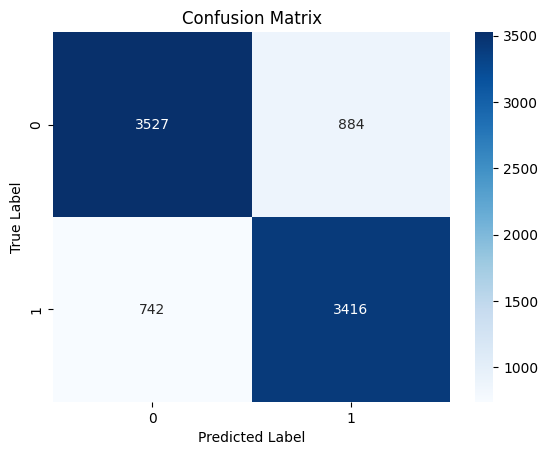

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Suponiendo que ya has entrenado el modelo:
# exported_pipeline.fit(X_train, y_train)
# results = exported_pipeline.predict(X_test)

# Exactitud (accuracy)
acc = accuracy_score(y_test, results)
print(f"Accuracy: {acc:.4f}")

# Reporte de clasificación
report = classification_report(y_test, results)
print("Classification Report:")
print(report)

# Matriz de confusión
cm = confusion_matrix(y_test, results)
print("Confusion Matrix:")
print(cm)

# (Opcional) Visualizar la matriz de confusión con seaborn
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
